# How to Write a Hit Song

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import klib
import tqdm
import warnings

# !pip install scikit-learn==1.6.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, MaxAbsScaler, QuantileTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import median_abs_deviation

# !pip install lightgbm==4.6.0
import lightgbm as lgb

# !pip install optuna==4.3.0
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate

# !pip install shap==0.47.2
import shap


In [572]:
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("display.max_columns", None)

### Variables

In [573]:
plt.style.use("dark_background")

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#cccccc'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#404040'  # dark grey
    
plt.rcParams['axes.axisbelow'] = True

In [574]:
color = 'limegreen'

### Load Data

https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated

In [575]:
df = pd.read_csv(r'universal_top_spotify_songs.csv')

df

spotify_id                               name  \
0        2RkZ5LkEzeHGRsmDqKwmaJ                           Ordinary   
1        27xkOIER6uDLKALIelHylZ              Don’t Say You Love Me   
2        7so0lgd0zP2Sbgs2d7a1SZ                   Die With A Smile   
3        0FTmksd2dxiE5e3rWyJXs6                    back to friends   
4        6dOtVTDdiauQNBQEDOtlAB                 BIRDS OF A FEATHER   
...                         ...                                ...   
2077911  0AYt6NMyyLd0rLuvr0UkMH          Slime You Out (feat. SZA)   
2077912  2Gk6fi0dqt91NKvlzGsmm7  SAY MY GRACE (feat. Travis Scott)   
2077913  26b3oVLrRUaaybJulow9kz                             People   
2077914  5ydjxBSUIDn26MFzU3asP4                         Rainy Days   
2077915  59NraMJsLaMCVtwXTSia8i                              Prada   

                             artists  daily_rank  daily_movement  \
0                        Alex Warren           1               0   
1                                Jin           2               0   
2              Lady Gaga, Bruno Mars           3               0   
3                              sombr           4               1   
4                      Billie Eilish           5              -1   
...                              ...         ...             ...   
2077911                   Drake, SZA          46               4   
2077912         Offset, Travis Scott          47               3   
2077913                     Libianca          48               2   
2077914                            V          49               1   
2077915  cassö, RAYE, D-Block Europe          50               0   

         weekly_movement country snapshot_date  popularity  is_explicit  \
0                      1     NaN    2025-06-02          94        False   
1                     -1     NaN    2025-06-02          91        False   
2                      0     NaN    2025-06-02          91        False   
3                      1     NaN    2025-06-02          97        False   
4                     -1     NaN    2025-06-02         100        False   
...                  ...     ...           ...         ...          ...   
2077911                0      AE    2023-10-18          84         True   
2077912                0      AE    2023-10-18          80         True   
2077913                0      AE    2023-10-18          88        False   
2077914                0      AE    2023-10-18          88        False   
2077915                0      AE    2023-10-18          94         True   

         duration_ms                          album_name album_release_date  \
0             186964  You'll Be Alright, Kid (Chapter 1)         2024-09-26   
1             180716                                Echo         2025-05-16   
2             251667                              MAYHEM         2025-03-07   
3             199032                     back to friends         2024-12-27   
4             210373                HIT ME HARD AND SOFT         2024-05-17   
...              ...                                 ...                ...   
2077911       310490                    For All The Dogs         2023-10-06   
2077912       173253                          SET IT OFF         2023-10-13   
2077913       184791                              People         2022-12-06   
2077914       179560                             Layover         2023-08-11   
2077915       132359                               Prada         2023-08-11   

         danceability  energy  key  loudness  mode  speechiness  acousticness  \
0               0.368   0.694    2    -6.141     1       0.0600      0.704000   
1               0.729   0.562    8    -5.490     1       0.0304      0.484000   
2               0.519   0.601    6    -7.727     0       0.0317      0.289000   
3               0.436   0.723    1    -2.291     1       0.0301      0.000094   
4               0.747   0.507    2   -10.171     1       0.0358      0.200000   
...               ...     .

In [576]:
checkpoint_df = df.copy()

In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077916 entries, 0 to 2077915
Data columns (total 25 columns):
 #   Column              Dtype  
---  ------              -----  
 0   spotify_id          object 
 1   name                object 
 2   artists             object 
 3   daily_rank          int64  
 4   daily_movement      int64  
 5   weekly_movement     int64  
 6   country             object 
 7   snapshot_date       object 
 8   popularity          int64  
 9   is_explicit         bool   
 10  duration_ms         int64  
 11  album_name          object 
 12  album_release_date  object 
 13  danceability        float64
 14  energy              float64
 15  key                 int64  
 16  loudness            float64
 17  mode                int64  
 18  speechiness         float64
 19  acousticness        float64
 20  instrumentalness    float64
 21  liveness            float64
 22  valence             float64
 23  tempo               float64
 24  time_signature      int6

### EDA

##### Features

In [578]:
categorical_features = [
                        # 'country',
                        # 'is_explicit',
                        # 'artists',
                        'time_signature',
                        'key',
                        ]

In [579]:
music_features = ['danceability',
                    'energy',
                    'loudness',
                    'mode',
                    'speechiness',
                    'acousticness',
                    'instrumentalness',
                    'liveness',
                    'valence',
                    'tempo',
                    'duration_ms',
                        ]

In [580]:
features =  music_features + categorical_features
target = 'popularity'

##### Describe & Distributions

In [581]:
df.describe(include=[object])

spotify_id                name        artists  country  \
count                  2077916             2077886        2077887  2049458   
unique                   24611               21499          13547       72   
top     6dOtVTDdiauQNBQEDOtlAB  BIRDS OF A FEATHER  Billie Eilish       DO   
freq                     16396               16396          32189    28726   

       snapshot_date            album_name album_release_date  
count        2077916               2077094            2077257  
unique           574                 16208               2941  
top       2024-03-16  HIT ME HARD AND SOFT         2024-05-17  
freq            3942                 30415              34390

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


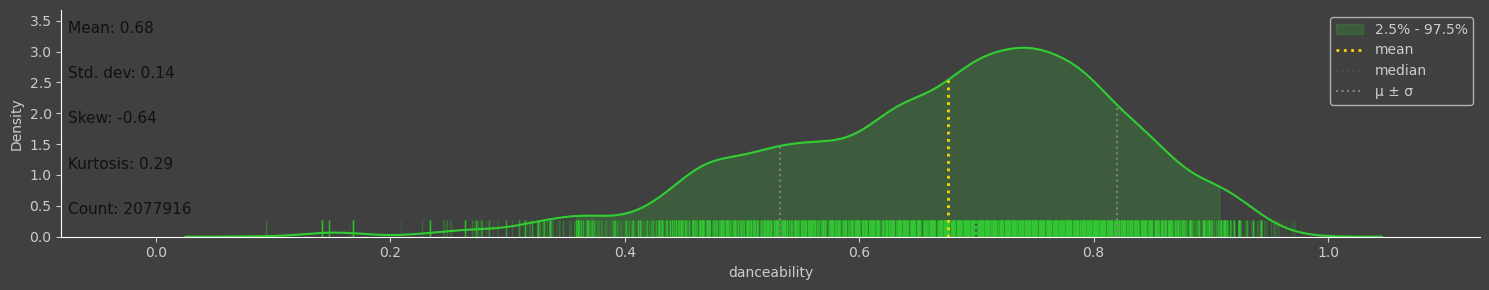

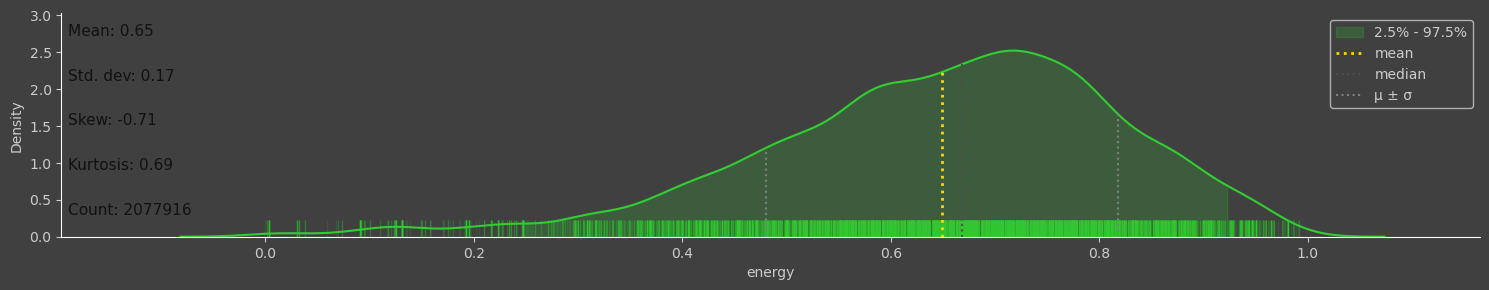

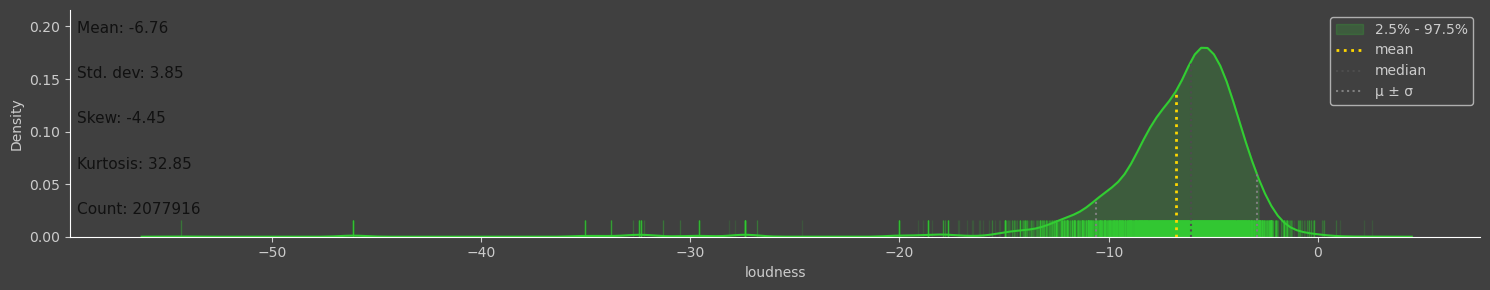

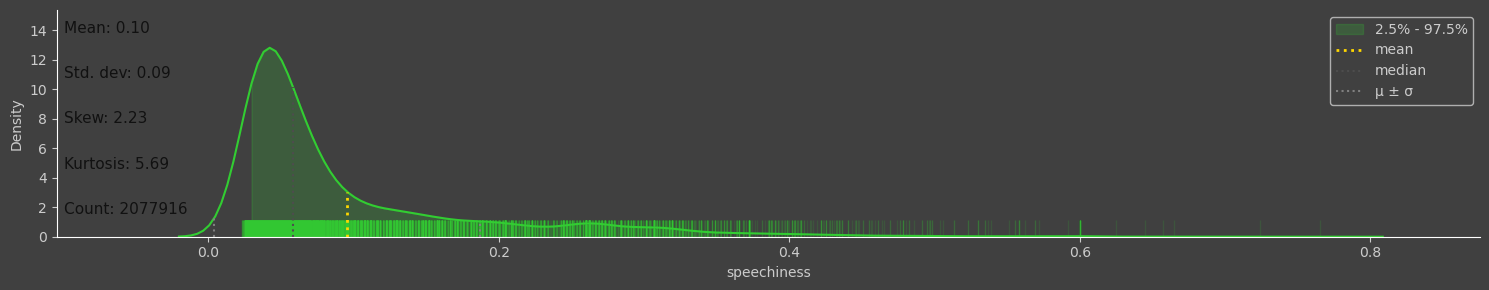

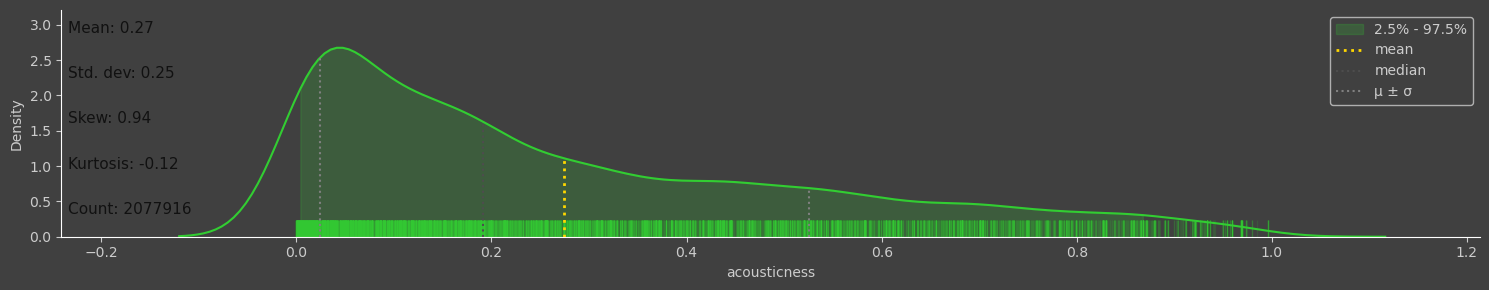

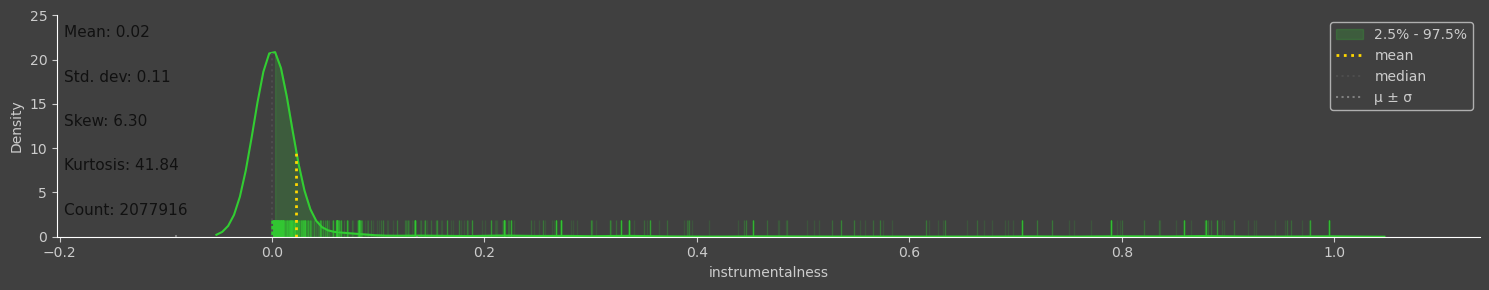

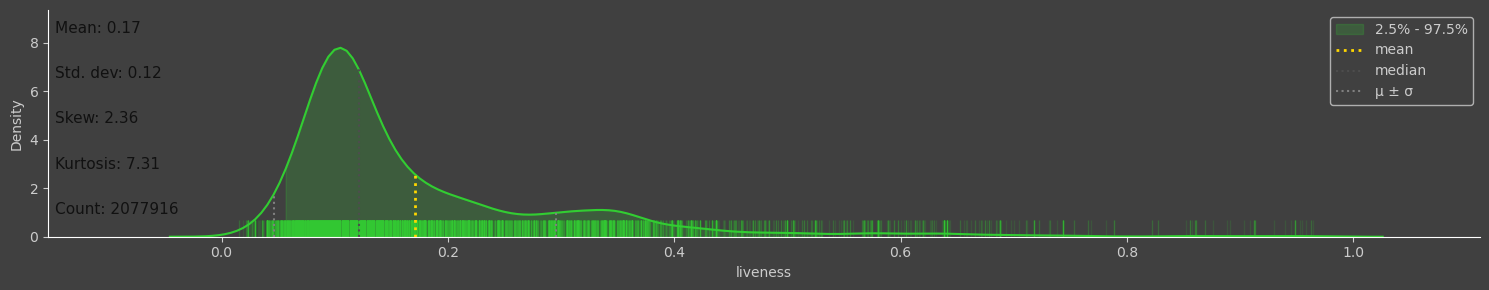

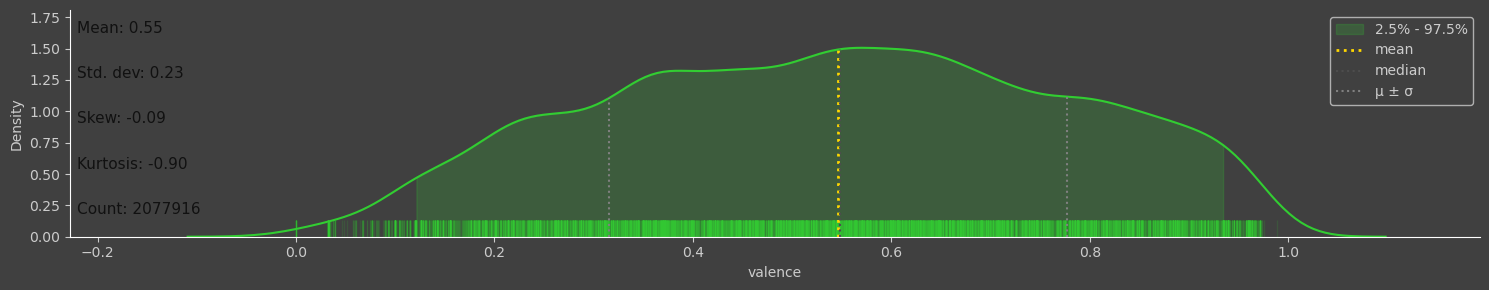

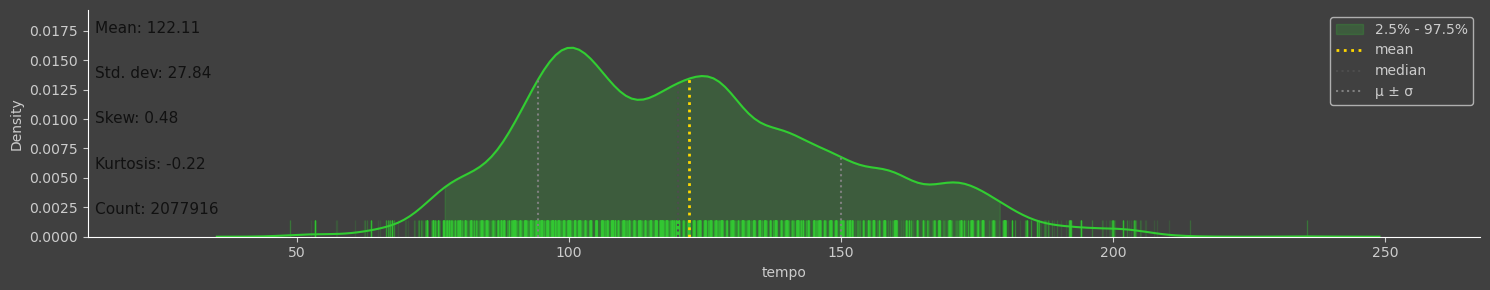

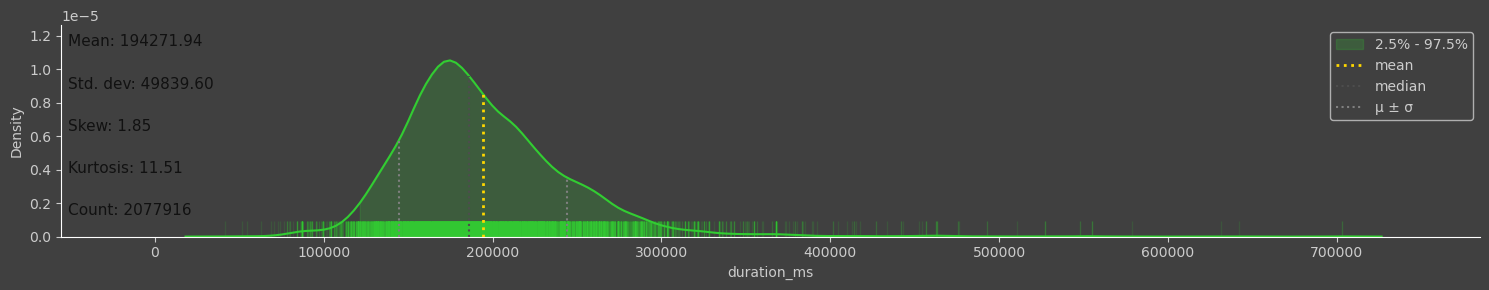

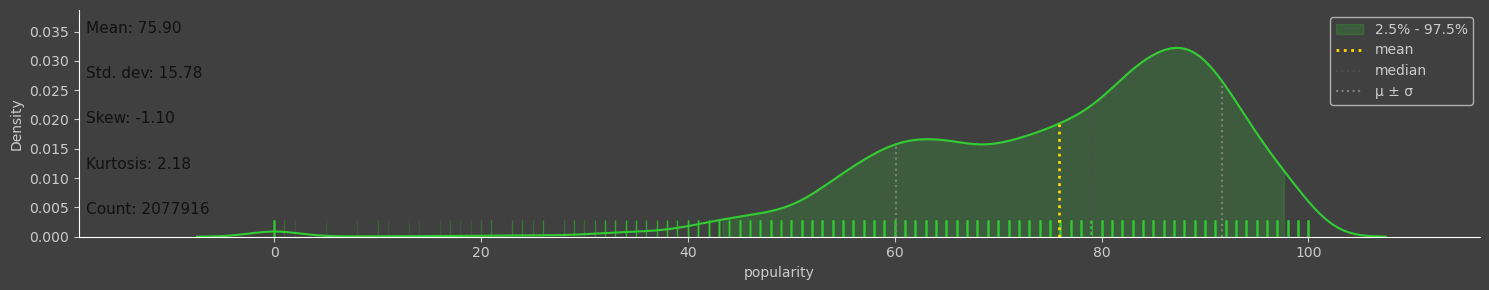

In [582]:
# Distribution plots
distplots = df[music_features + [target]].copy()

klib.dist_plot(distplots, showall=True, 
                kde_kws ={'color' : color},
                fill_kws = {'color': color, 'alpha':0.2},
                rug_kws = {'color': color, 'alpha':0.15, 'lw':3, 'height':0.075},
                mean_color = 'gold',
                )
plt.show()

##### Investigate Tails

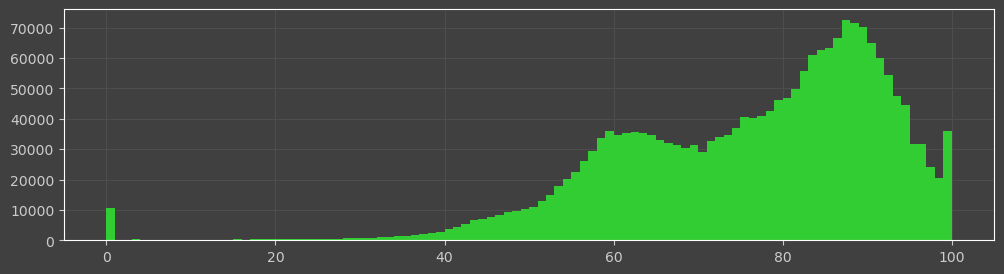

In [583]:
# Plotting a histogram to show the spread of Popularity since we notice some strange stats worth investigating
plt.figure(figsize=(12,3))
plt.hist(df['popularity'],bins=100, color='limegreen')
plt.grid(color='#4d4d4d')
plt.show()

In [584]:
# Investigating low popularity
df.loc[df['popularity']==0]

spotify_id           name          artists  daily_rank  \
1038     7rPCoHeFhATM6JiiNKw5fL          G Luv  1550 Collective          39   
3720     5q5411GrxghqJuBqIZklhJ        Nhớ Ems  Rocky CDE, Khan          21   
4606     7LnIjqQ777a9YdPQXkAAOy       Nicotine            SAJKA           7   
7316     5q5411GrxghqJuBqIZklhJ        Nhớ Ems  Rocky CDE, Khan          17   
7424     0mmWol32PnowJQf0rZx5ab       Golfista             Duki          25   
...                         ...            ...              ...         ...   
2075225  3zSSCPpLZ5Oc8nelhhGjKz   Tu hai kahan              AUR           1   
2075670  6yxtsR3nc3aUL1wcbLn8A3      Jaga Jaga       VicK, Babi          46   
2076218  3zSSCPpLZ5Oc8nelhhGjKz   Tu hai kahan              AUR           3   
2077875  7z8EC940EnKqsHQGz5NwEe       Rockstar        Jay Chang          10   
2077876  5O1ItjDBMl2IIrmRlYhbUe  I'll Be There        Jay Chang          11   

         daily_movement  weekly_movement country snapshot_date  popularity  \
1038                 11               11      PH    2025-06-02           0   
3720                 -4               29      VN    2025-06-01           0   
4606                 43               43      PH    2025-06-01           0   
7316                 33               33      VN    2025-05-31           0   
7424                 25               25      UY    2025-05-31           0   
...                 ...              ...     ...           ...         ...   
2075225              49                0      PK    2023-10-18           0   
2075670               4                0      NG    2023-10-18           0   
2076218              47                0      IN    2023-10-18           0   
2077875              40                0      AE    2023-10-18           0   
2077876              39                0      AE    2023-10-18           0   

         is_explicit  duration_ms     album_name album_release_date  \
1038            True       436498          G Luv         2024-03-25   
3720           False       214400        Nhớ Ems         2022-07-07   
4606            True       120707  Weed&Melodies         2025-05-01   
7316           False       214400        Nhớ Ems         2022-07-07   
7424           False       158927       Golfista         2025-05-29   
...              ...          ...            ...                ...   
2075225        False       263184   Tu hai kahan         2023-10-16   
2075670        False       226644      Jaga Jaga         2023-10-04   
2076218        False       263184   Tu hai kahan         2023-10-16   
2077875        False       192173     Late Night         2023-10-17   
2077876        False       197418     Late Night         2023-10-17   

         danceability  energy  key  loudness  mode  speechiness  acousticness  \
1038            0.562   0.601    8    -9.218     0       0.2860       0.05860   
3720            0.810   0.429    0   -12.252     1       0.0789       0.40800   
4606            0.615   0.714    8    -6.635     1       0.1180       0.60100   
7316            0.810   0.429    0   -12.252     1       0.0789       0.40800   
7424            0.775   0.751    1    -3.854     1       0.0522       0.00121   
...               ...     ...  ...       ...   ...          ...           ...   
2075225         0.708   0.356    1    -9.738     1       0.0750       0.43700   
2075670         0.791   0.515    1    -8.178     0       0.1680       0.55400   
2076218         0.708   0.356    1    -9.738     1       0.0750       0.43700   
2077875         0.636   0.973    6    -1.429     1       0.0942       0.20200   
2077876         0.691   0.843    4    -3.616     1       0.0555       0.11500   

         instrumentalness  liveness  valence    tempo  time_signature  
1038             0.000000    0.1400    0.698  193.853               4  
3720             0.000000    0.1440    0.330   90.036               4  
4606             0.000116    0.1590    0.460  128.037               4  
7316             0.00

In [585]:
# Drop all 0's
df = df[df['popularity'] > 1] 

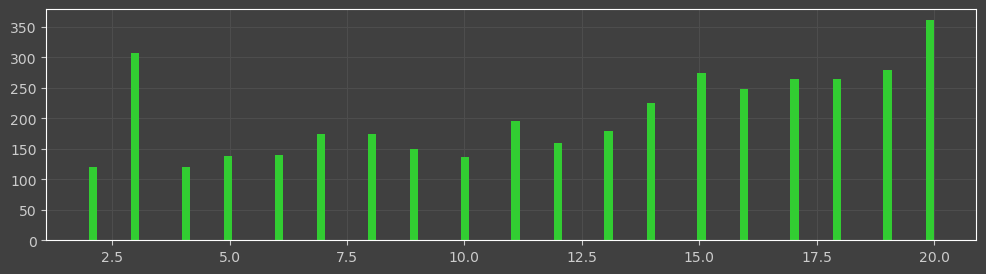

In [586]:
# Looking at the left tail
plt.figure(figsize=(12,3))
plt.hist(df.loc[df['popularity']<=20]['popularity'],bins=100, color='limegreen')
plt.grid(color='#4d4d4d')
plt.show()

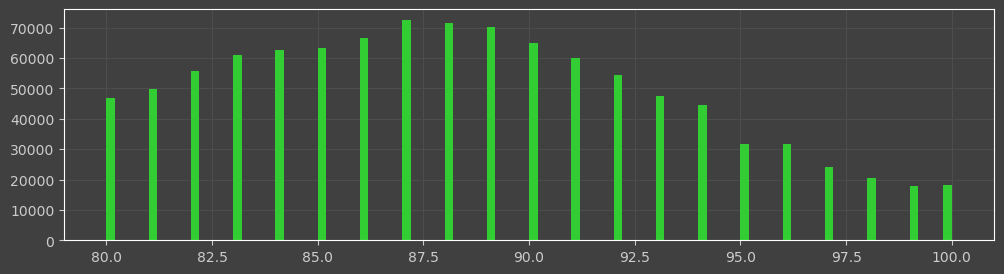

In [587]:
# Looking at the right tail
plt.figure(figsize=(12,3))
plt.hist(df.loc[df['popularity']>=80]['popularity'],bins=100, color='limegreen')
plt.grid(color='#4d4d4d')
plt.show()

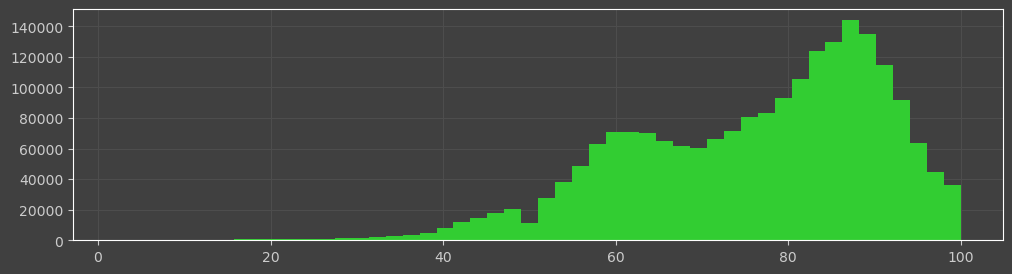

In [588]:
# Plotting a histogram to show the spread of Popularity since we notice some strange stats worth investigating
plt.figure(figsize=(12,3))
plt.hist(df['popularity'],bins=50, color='limegreen')
plt.grid(color='#4d4d4d')
plt.show()

##### Missing Values

In [589]:
df.isna().sum()

spotify_id                0
name                      0
artists                   0
daily_rank                0
daily_movement            0
weekly_movement           0
country               28212
snapshot_date             0
popularity                0
is_explicit               0
duration_ms               0
album_name              792
album_release_date      630
danceability              0
energy                    0
key                       0
loudness                  0
mode                      0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
time_signature            0
dtype: int64

### Feature Engineering & Pre-Processing

In [590]:
def transform_target(data, target):

    # Define min and max of your target range
    min_val = data[target].min()
    max_val = data[target].max()
    # Small epsilon to avoid log(0) or division by zero
    epsilon = 1e-6

    # MinMax Scale target to (0, 1)
    y_train_scaled = (data[target] - min_val) / (max_val - min_val)

    # Apply epsilon to ensure values are strictly within (0, 1) for logit
    y_train_scaled = np.clip(y_train_scaled, epsilon, 1 - epsilon)

    # Apply Logit transformation
    target_transformed = np.log(y_train_scaled / (1 - y_train_scaled))

    return target_transformed, min_val, max_val

In [591]:
# Make a copy to visualize
original_target = df[target].copy()

# Transform
df.loc[: , target], min_val, max_val  = transform_target(df, target)


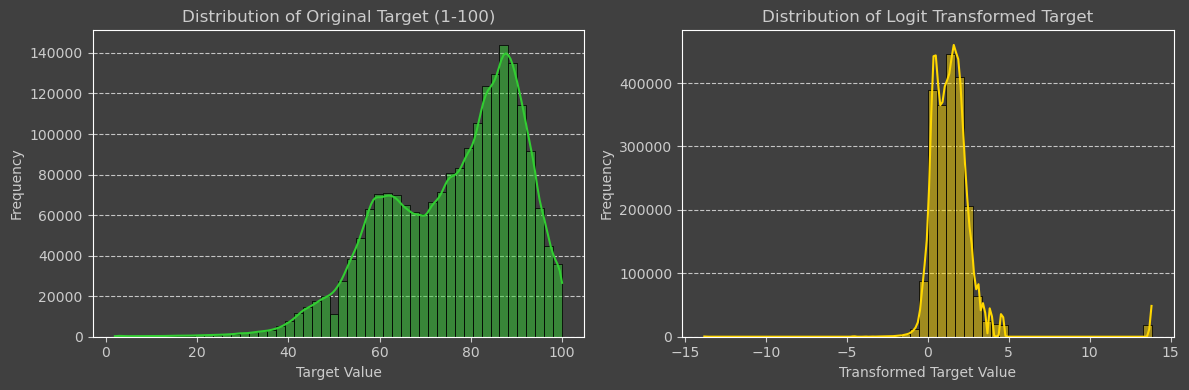

In [592]:

# Plotting the Histograms
plt.figure(figsize=(12, 4)) # Adjust figure size for better side-by-side viewing

# Histogram of Original Target
plt.subplot(1, 2, 1)
sns.histplot(original_target, bins=50, kde=True, color=color, edgecolor='black')
plt.title('Distribution of Original Target (1-100)')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Histogram of Transformed Target
plt.subplot(1, 2, 2)
sns.histplot(df[target], bins=50, kde=True, color='gold', edgecolor='black')
plt.title('Distribution of Logit Transformed Target')
plt.xlabel('Transformed Target Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Scale

In [593]:
# scaler = StandardScaler()
# df.loc[:, music_features] = scaler.fit_transform(df[music_features])

#### Interactions

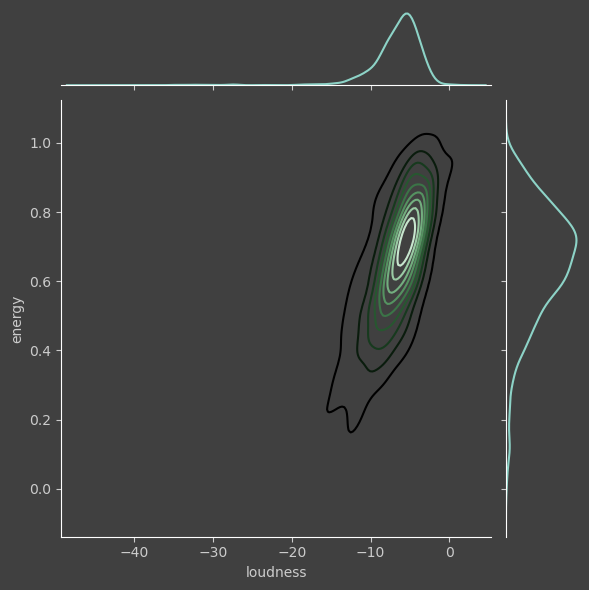

In [ ]:
# analysing the relationship between  loudness vs energy
j_df = df.sample(2000)
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True, start=5, rot=0)
sns.jointplot(x=j_df['loudness'], y=j_df['energy'], data=df, kind="kde", cmap=cmap)
plt.show()


In [ ]:
# Create an interaction term
df.loc[:, 'loudness_x_energy'] = df['loudness'] * df['energy']

music_features.append('loudness_x_energy')
features.append('loudness_x_energy')

/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_74885/1328019204.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### KNN - Country Matching

In [596]:
df['country'].unique().tolist()

[nan,
 'ZA',
 'VN',
 'VE',
 'UY',
 'US',
 'UA',
 'TW',
 'TR',
 'TH',
 'SV',
 'SK',
 'SG',
 'SE',
 'SA',
 'RO',
 'PY',
 'PT',
 'PL',
 'PK',
 'PH',
 'PE',
 'PA',
 'NZ',
 'NO',
 'NL',
 'NI',
 'NG',
 'MY',
 'MX',
 'MA',
 'LV',
 'LU',
 'LT',
 'KZ',
 'KR',
 'JP',
 'IT',
 'IS',
 'IN',
 'IL',
 'IE',
 'ID',
 'HU',
 'HN',
 'HK',
 'GT',
 'GR',
 'FR',
 'FI',
 'ES',
 'EG',
 'EE',
 'EC',
 'DO',
 'DK',
 'DE',
 'CZ',
 'CR',
 'CO',
 'CL',
 'CH',
 'CA',
 'BY',
 'BR',
 'BO',
 'BG',
 'BE',
 'AU',
 'AT',
 'AR',
 'AE',
 'GB']

In [597]:
len(df['country'].unique().tolist())

73

In [598]:
df.loc[:, 'country'] = df['country'].fillna('INTERNATIONAL')

In [599]:
# df = df[df['country']=='US']
# df = df[df['country'].isin(['US', 'GB', 'INTERNATIONAL'])]
# df = df[df['country']=='INTERNATIONAL']

In [600]:
country_features_df = df.copy()

target_country = 'US'
n_neighbors_to_find = 20

# Aggregate data by country
country_features_df = country_features_df.groupby('country')[music_features].mean().reset_index()

# Separate the target country's data
us_data = country_features_df[country_features_df['country'] == target_country]
other_countries_data = country_features_df[country_features_df['country'] != target_country]

# Scale data, fit on all
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(country_features_df[music_features])

# Transform each seperately
X_other_scaled = scaler.transform(other_countries_data[music_features])
X_us_scaled = scaler.transform(us_data[music_features])

# Apply NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors_to_find, metric='euclidean')
knn.fit(X_other_scaled) # Fit on the scaled data of other countries

# Find the k-nearest neighbors (distances and indices)
distances, indices = knn.kneighbors(X_us_scaled)

# Convert indices to actual country names
closest_country_indices = indices.flatten()
closest_countries_df = other_countries_data.iloc[closest_country_indices].copy()

# Add distances to the results DataFrame
closest_countries_df['Distance'] = distances.flatten()

# Sort by distance
closest_countries_df = closest_countries_df.sort_values(by='Distance').reset_index(drop=True)
knn_countries_list = closest_countries_df['country'].unique().tolist()

print(f"KNN Matching - The {n_neighbors_to_find} most similar countries to {target_country}")
knn_countries_list

KNN Matching - The 20 most similar countries to US


['CA',
 'AE',
 'IE',
 'INTERNATIONAL',
 'AU',
 'NZ',
 'GB',
 'SE',
 'NO',
 'SG',
 'CH',
 'LV',
 'BE',
 'TW',
 'PH',
 'LU',
 'MY',
 'TH',
 'AT',
 'NL']

In [601]:
# Add the US to the filter list
knn_countries_list.append('US')

In [602]:
# Filter for these countries only
# df = df[df['country'].isin(knn_countries_list)]

#### Aggregate Years

In [603]:
# Extract the year and create a new column
df.loc[:, 'year'] = pd.to_datetime(df.loc[:, 'snapshot_date']).dt.year

/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_74885/3346244298.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [604]:
df['year'].value_counts()

year
2024    1276366
2025     519270
2023     271581
Name: count, dtype: int64

In [605]:
# Group and aggregate musical features
group_cols = ['name'] + categorical_features
group_cols

['name', 'time_signature', 'key']

In [606]:
# All music_features will take the mean
aggregation_dict = {col: 'mean' for col in music_features }

# With some exceptions
aggregation_dict['year'] = 'max' 
aggregation_dict['snapshot_date'] = 'count' 
aggregation_dict['country'] = 'nunique' 

# The target variable will take the maximum.
aggregation_dict[target] = 'max' 

aggregation_dict

{'danceability': 'mean',
 'energy': 'mean',
 'loudness': 'mean',
 'mode': 'mean',
 'speechiness': 'mean',
 'acousticness': 'mean',
 'instrumentalness': 'mean',
 'liveness': 'mean',
 'valence': 'mean',
 'tempo': 'mean',
 'duration_ms': 'mean',
 'loudness_x_energy': 'mean',
 'year': 'max',
 'snapshot_date': 'count',
 'country': 'nunique',
 'popularity': 'max'}

In [607]:
# Aggregate
df = df.groupby(group_cols).agg(aggregation_dict).reset_index()

In [608]:
# Rename new features
df = df.rename(columns={'snapshot_date':'number_of_days', 
                        'year':'max_year', 
                        'country':'total_countries'})

In [609]:
# Add new features to the list
features.extend(['max_year', 'number_of_days', 'total_countries'])
music_features.extend(['max_year', 'number_of_days', 'total_countries'])

In [610]:
len(df)

21822

In [611]:
df = df.drop_duplicates(subset='name')

In [612]:
len(df)

20882

In [613]:
df

name  time_signature  key  \
0                              "Heal'lang"(folang)               4    2   
1                                             "Se"               4    7   
2      "Slut!" (Taylor's Version) (From The Vault)               4    7   
3                                     "conspiracy"               4   10   
4                                       #BÂTIMENT1               4    1   
...                                            ...             ...  ...   
21817                              별별별 (See that?)               4    8   
21818                              보나마나 (BONAMANA)               4    0   
21819                                          예뻤어               4    5   
21820                                         작은 봄               4    4   
21821                                한 페이지가 될 수 있게               4    8   

       danceability  energy  loudness  mode  speechiness  acousticness  \
0             0.900   0.759    -4.459   1.0       0.1780       0.04290   
1             0.740   0.765    -5.569   0.0       0.0622       0.18600   
2             0.629   0.413   -13.178   1.0       0.0550       0.34500   
3             0.842   0.402    -8.241   0.0       0.2470       0.10000   
4             0.673   0.565    -8.606   1.0       0.1610       0.56600   
...             ...     ...       ...   ...          ...           ...   
21817         0.603   0.824    -2.928   1.0       0.2750       0.03590   
21818         0.800   0.389    -9.987   0.0       0.0550       0.52300   
21819         0.460   0.615    -3.472   0.0       0.0331       0.06330   
21820         0.586   0.581    -6.300   1.0       0.0248       0.05780   
21821         0.510   0.975    -2.758   1.0       0.0530       0.00428   

       instrumentalness  liveness  valence    tempo  duration_ms  \
0              0.000006    0.2280   0.5960  125.001     273711.0   
1              0.488000    0.1350   0.5480  131.986     145511.0   
2              0.000076    0.0603   0.3060   77.983     180381.0   
3              0.000000    0.1060   0.3140  149.930     183003.0   
4              0.000000    0.1110   0.0857  148.988     129522.0   
...                 ...       ...      ...      ...          ...   
21817          0.000000    0.1130   0.5270  183.936     182795.0   
21818          0.000000    0.1190   0.6850  129.861     195536.0   
21819          0.000000    0.1090   0.4140  167.927     283160.0   
21820          0.000000    0.1130   0.2680  109.969     222040.0   
21821          0.000000    0.2220   0.7470  174.973     205575.0   

       loudness_x_energy  max_year  number_of_days  total_countries  \
0              -3.384381      2025               2                1   
1              -4.260285      2024               7                1   
2              -5.442514      2024             300               32   
3              -3.312882      2024               1                1   
4              -4.862390      2024               1                1   
...                  ...       ...             ...              ...   
21817          -2.412672      2024               3                1   
21818          -3.884943      2025               5                3   
21819          -2.135280      2024               7                1   
21820          -3.660300      2025              10                1   
21821          -2.689050      2025              13                1   

       popularity  
0        0.246133  
1        0.122602  
2        2.291412  
3       -2.174752  
4       -0.163629  
...           ...  
21817    0.246133  
21818    0.329479  
21819    0.040822  
21820    0.122602  
21821    0.163629  

[20882 rows x 19 columns]

#### Correlation

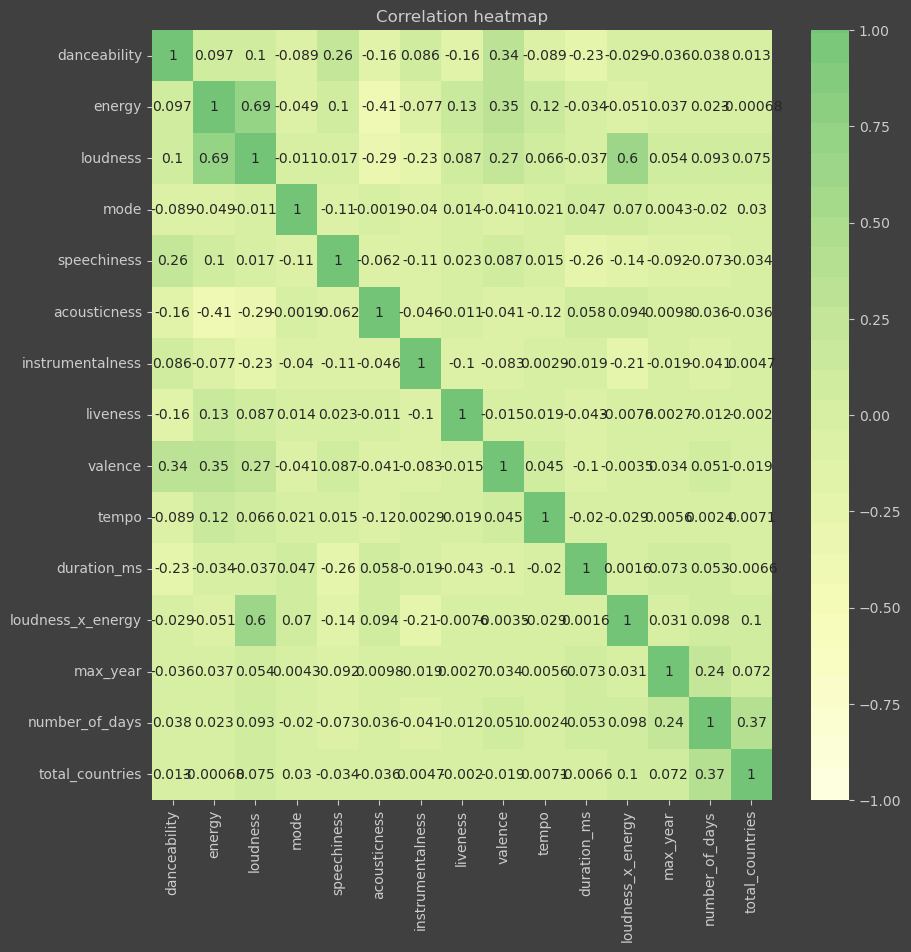

In [614]:
# Use a spearman correlation to measure the relationship between features
correlation = df[music_features].corr(method='spearman')

# Heatmap of the correlation to visualize the relationships between features
plt.figure(figsize=(10,10))
plt.title('Correlation heatmap')
cmap = sns.color_palette("YlGn", 50)
sns.heatmap(correlation, annot = True, vmin=-1, vmax=1, cmap=cmap, center=1)

plt.show()

#### Outliers

In [615]:
def mod_zscore_outliers(data, feature_list, threshold=3.5): 

    for col in feature_list:

        median_val = data[col].median()
        mad_val = median_abs_deviation(data[col], scale = 'normal')
        mod_zscore = (data[col]-median_val)/mad_val

        data[col + '_outlier'] = np.where(np.abs(mod_zscore) > threshold , 1, 0)

    return data

In [616]:
scaler = StandardScaler()
df.loc[:, music_features] = scaler.fit_transform(df.loc[:, music_features])

df = mod_zscore_outliers(df, music_features, threshold=5)

df.loc[:, music_features] = scaler.inverse_transform(df.loc[:, music_features])

df

name  time_signature  key  \
0                              "Heal'lang"(folang)               4    2   
1                                             "Se"               4    7   
2      "Slut!" (Taylor's Version) (From The Vault)               4    7   
3                                     "conspiracy"               4   10   
4                                       #BÂTIMENT1               4    1   
...                                            ...             ...  ...   
21817                              별별별 (See that?)               4    8   
21818                              보나마나 (BONAMANA)               4    0   
21819                                          예뻤어               4    5   
21820                                         작은 봄               4    4   
21821                                한 페이지가 될 수 있게               4    8   

       danceability  energy  loudness  mode  speechiness  acousticness  \
0             0.900   0.759    -4.459   1.0       0.1780       0.04290   
1             0.740   0.765    -5.569   0.0       0.0622       0.18600   
2             0.629   0.413   -13.178   1.0       0.0550       0.34500   
3             0.842   0.402    -8.241   0.0       0.2470       0.10000   
4             0.673   0.565    -8.606   1.0       0.1610       0.56600   
...             ...     ...       ...   ...          ...           ...   
21817         0.603   0.824    -2.928   1.0       0.2750       0.03590   
21818         0.800   0.389    -9.987   0.0       0.0550       0.52300   
21819         0.460   0.615    -3.472   0.0       0.0331       0.06330   
21820         0.586   0.581    -6.300   1.0       0.0248       0.05780   
21821         0.510   0.975    -2.758   1.0       0.0530       0.00428   

       instrumentalness  liveness  valence    tempo  duration_ms  \
0              0.000006    0.2280   0.5960  125.001     273711.0   
1              0.488000    0.1350   0.5480  131.986     145511.0   
2              0.000076    0.0603   0.3060   77.983     180381.0   
3              0.000000    0.1060   0.3140  149.930     183003.0   
4              0.000000    0.1110   0.0857  148.988     129522.0   
...                 ...       ...      ...      ...          ...   
21817          0.000000    0.1130   0.5270  183.936     182795.0   
21818          0.000000    0.1190   0.6850  129.861     195536.0   
21819          0.000000    0.1090   0.4140  167.927     283160.0   
21820          0.000000    0.1130   0.2680  109.969     222040.0   
21821          0.000000    0.2220   0.7470  174.973     205575.0   

       loudness_x_energy  max_year  number_of_days  total_countries  \
0              -3.384381    2025.0             2.0              1.0   
1              -4.260285    2024.0             7.0              1.0   
2              -5.442514    2024.0           300.0             32.0   
3              -3.312882    2024.0             1.0              1.0   
4              -4.862390    2024.0             1.0              1.0   
...                  ...       ...             ...              ...   
21817          -2.412672    2024.0             3.0              1.0   
21818          -3.884943    2025.0             5.0              3.0   
21819          -2.135280    2024.0             7.0              1.0   
21820          -3.660300    2025.0            10.0              1.0   
21821          -2.689050    2025.0            13.0              1.0   

       popularity  danceability_outlier  energy_outlier  loudness_outlier  \
0        0.246133                     0               0                 0   
1        0.122602                     0               0                 0   
2        2.291412                     0               0                 0   
3       -2.174752                     0               0                 0   
4       -0.163629                     0               0                 0   
...           ...                   ...             ...               ...   
21817    0.246133                     0        

In [617]:
# Count outliers
df[[f + '_outlier' for f in music_features]].sum()

danceability_outlier             0
energy_outlier                   0
loudness_outlier               201
mode_outlier                 10214
speechiness_outlier           1386
acousticness_outlier             0
instrumentalness_outlier      8054
liveness_outlier              1112
valence_outlier                  0
tempo_outlier                    0
duration_ms_outlier            235
loudness_x_energy_outlier       35
max_year_outlier              9851
number_of_days_outlier        4313
total_countries_outlier       4343
dtype: int64

In [618]:
# Add outliers as features
music_features.append('loudness_x_energy_outlier') 
features.append('loudness_x_energy_outlier') 

#### VIF Filtering

In [619]:

def calculate_vif(X_df, thresh=5.0):
    """
    Calculates Variance Inflation Factor (VIF) for features in a DataFrame
    and iteratively drops features with VIF above a specified threshold.

    Parameters:
    X_df (pd.DataFrame): The input DataFrame containing only the independent variables.
                        It's important that this DataFrame does NOT include the target variable.
    thresh (float): The VIF threshold. Features with VIF greater than this
                    threshold will be dropped. Common thresholds are 5 or 10.

    Returns:
    tuple:
        - pd.DataFrame: The DataFrame with features remaining after VIF-based dropping.
        - list: A list of feature names that were dropped.
    """

    drop_list = [] 
    X = X_df.copy()

    # Loop continues as long as a feature was dropped in the previous iteration
    dropped = True 
    while dropped: 
        # Reset the flag for the current iteration. If no feature is dropped, loop will exit.
        dropped = False 

        # Add a constant to the data, 'has_constant='add'' ensures a constant is added if one doesn't exist.
        X_with_const = add_constant(X, has_constant='add')

        # Calculate VIF for each feature
        # X.columns[1:] refers to the columns *after* the constant term (which is usually at index 0).
        temp_df = pd.DataFrame({
            'feature': X_with_const.columns[1:],
            'vif': [variance_inflation_factor(X_with_const.values, i + 1)
                    for i in range(len(X_with_const.columns[1:]))]
        })

        # Identify the feature with the highest VIF
        maxloc = temp_df['vif'].idxmax()
        max_vif = temp_df.loc[maxloc, 'vif']
        max_feature = temp_df.loc[maxloc, 'feature']

        # Decision to drop based on threshold
        if max_vif > thresh:
            print(f'Dropping {max_feature} with VIF: {max_vif:.3f}')
            X.drop(columns=[max_feature], inplace=True)
            drop_list.append(max_feature)
            dropped = True
        else:
            # If the max VIF is not above the threshold, no more features need to be dropped.
            dropped = False
            print(f"No features to drop. Max VIF is {max_vif:.3f} (below threshold {thresh}).")

    return X, drop_list

In [620]:
df_vif, drop_list = calculate_vif(df[music_features], thresh=5.0)
drop_list

Dropping loudness with VIF: 5.903
No features to drop. Max VIF is 1.696 (below threshold 5.0).


['loudness']

In [621]:
# Drop VIF selected features
df.drop(drop_list, axis=1, inplace=True)

music_features = [f for f in music_features if f not in drop_list]
features = [f for f in features if f not in drop_list]

#### Split the Data - Train, Eval, and Test Sets

In [622]:
X = df[features]
y = df[target]

# Split into train and val/test by percentage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the temp set into validation and test sets 50% each
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### LightGBM Regression

#### Fit & Evaluate Model

In [623]:
# Identify object columns
object_cols = X_train.select_dtypes(include='object').columns

# Convert identified columns to 'category'
for col in object_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [624]:
# Parameters for the current model
current_params = {
    'objective': 'regression',
    'metric': 'rmse',  
    'boosting_type': 'gbdt',
    'n_estimators':5000,
    'learning_rate': 0.05,
    'num_leaves': 62,
    'max_depth': 100,
    'min_child_samples':10,
    'lambda_l1':0.1, 
    'lambda_l2':0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
}

In [625]:
categorical_features

['time_signature', 'key']

In [626]:
# Initialize the LightGBMRegressor
lgbm_model = lgb.LGBMRegressor(**current_params)

# Train the LightGBM model with early stopping
eval_set = [(X_train, y_train), (X_val, y_val)]
evals_result = {}

lgbm_model.fit(X_train, y_train,
                categorical_feature=categorical_features,
                eval_set=eval_set,
                eval_metric=['rmse', 'mae'], 
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=1),
                            lgb.record_evaluation(evals_result)])

# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's l1: 0.402759	training's rmse: 0.603416	valid_1's l1: 0.460637	valid_1's rmse: 0.799574


In [627]:
def inverse_transform_target(data, min_val, max_val):

    # Inverse Logit transformation
    data_scaled = 1 / (1 + np.exp(-data))

    # Inverse scaling back to original range
    data = data_scaled * (max_val - min_val) + min_val

    # Clip the final predictions to ensure they are strictly within 1-100 (optional, but good for robustness)
    data = np.clip(data, min_val, max_val)

    return data
    

In [628]:
# Inverse transform target and preds
y_pred = inverse_transform_target(y_pred, min_val, max_val)
y_test_inv_scaled = inverse_transform_target(y_test, min_val, max_val)

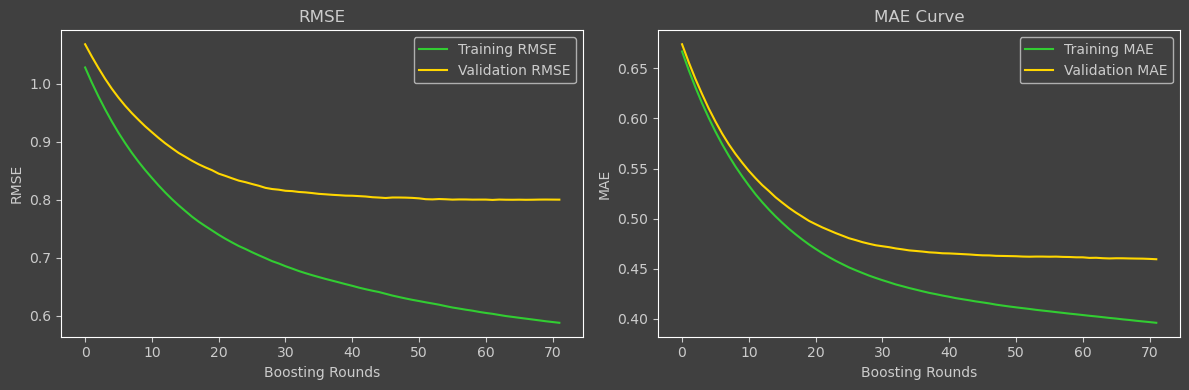

In [629]:
# Visualize the loss curves
epochs = len(evals_result['training']['rmse']) 
plt.figure(figsize=(12, 4))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(evals_result['training']['rmse'], label='Training RMSE', color = color)
plt.plot(evals_result['valid_1']['rmse'], label='Validation RMSE', color = 'gold')
plt.title('RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(evals_result['training']['l1'], label='Training MAE', color = color)
plt.plot(evals_result['valid_1']['l1'], label='Validation MAE', color = 'gold')
plt.title('MAE Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

##### Residual Analysis

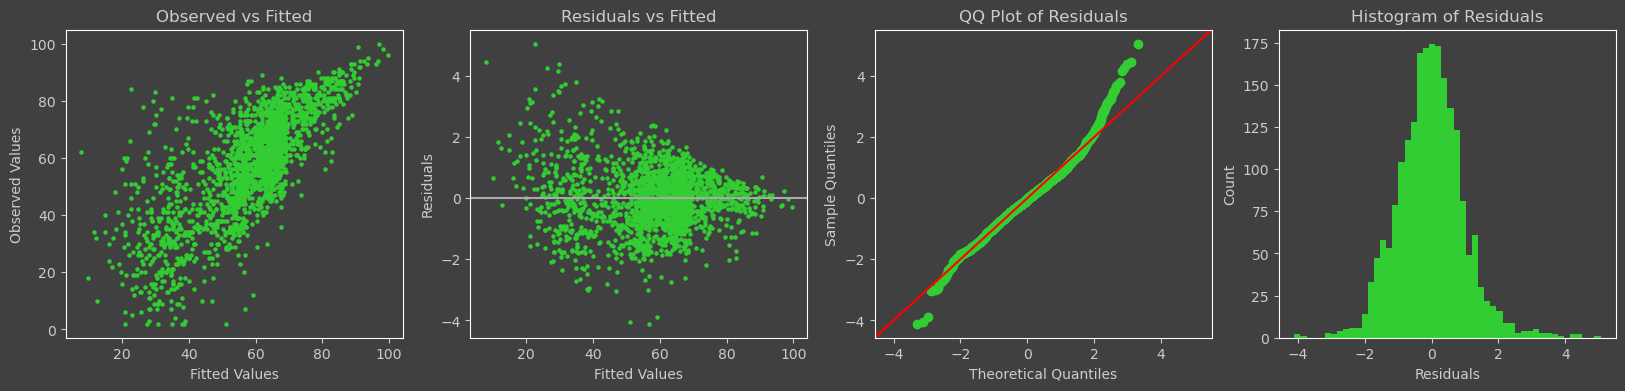

In [630]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

# Standardize residuals for multivariate regression
residuals = y_test_inv_scaled - y_pred
standardized_residuals = residuals / np.std(residuals)

# Observed vs Fitted
ax[0].scatter(x = y_pred, y = y_test_inv_scaled, s=5, c=color)
ax[0].set_title("Observed vs Fitted")
ax[0].set_xlabel("Fitted Values")
ax[0].set_ylabel("Observed Values")

# Residuals vs Fitted
ax[1].scatter(x = y_pred, y = standardized_residuals, s=5, c=color)
ax[1].axhline(y = 0, color='darkgrey')
ax[1].set_title("Residuals vs Fitted")
ax[1].set_xlabel("Fitted Values")
ax[1].set_ylabel("Residuals")

# QQ Plot of Residuals
sm.qqplot(standardized_residuals, line='45', fit=True, ax=ax[2], markerfacecolor=color, markeredgecolor=color)
ax[2].set_title("QQ Plot of Residuals")

# Histogram of Residuals
ax[3].hist(standardized_residuals, color=color, bins=50)
ax[3].set_title("Histogram of Residuals")
ax[3].set_xlabel("Residuals")
ax[3].set_ylabel("Count")

plt.show()


In [631]:
rmse = root_mean_squared_error(y_pred, y_test_inv_scaled)
rmse

12.131853847005182

#### Optuna

In [632]:
def objective(trial):
    """Objective function for Optuna to minimize."""
    params = {
        'objective': current_params['objective'],
        'metric': current_params['metric'],
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','goss']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0001, 0.5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0001, 0.5),
        'random_state': current_params['random_state'],
        'n_jobs': current_params['n_jobs']
    }

    model = lgb.LGBMRegressor(**params, verbose=-1)
    model.fit(X_train, y_train,
                categorical_feature=categorical_features,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)],
                )

    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_pred, y_val)

    return rmse

In [633]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Enqueue the current parameters as a starting point
study.enqueue_trial(current_params)

# Run the optimization
study.optimize(objective, n_trials=500,  show_progress_bar=False)  

[I 2025-06-08 09:03:53,522] A new study created in memory with name: no-name-750a071e-d847-4d99-bc43-6fdeee4d64fe
/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/optuna/trial/_trial.py:652: UserWarning:

Fixed parameter 'n_estimators' with value 5000 is out of range for distribution IntDistribution(high=2000, log=False, low=100, step=1).

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/optuna/trial/_trial.py:652: UserWarning:

Fixed parameter 'max_depth' with value 100 is out of range for distribution IntDistribution(high=30, log=False, low=-1, step=1).

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/optuna/trial/_trial.py:652: UserWarning:

Fixed parameter 'min_child_samples' with value 10 is out of range for distribution IntDistribution(high=50, log=False, low=20, step=1).

[I 2025-06-08 09:03:53,805] Trial 0 finished with value: 0.7931572068034674 and parameters: {'n_estimators': 5000, 'boosting_type': 'gbdt', 'learning_ra

In [634]:
# Visualize optimization history
fig_history = plot_optimization_history(study)
fig_history.show()

In [635]:
# Visualize parameter importances
fig_importance = plot_param_importances(study)
fig_importance.show()

In [636]:
# Visualize parallel coordinate plot (for multi-dimensional parameter relationships)
fig_parallel = plot_parallel_coordinate(study)
fig_parallel.show()


##### Select Best Params and Join Data

In [637]:
# Get the best parameters found by Optuna
best_params = study.best_params
print(f"Best parameters found by Optuna:\n")
for key, value in best_params.items():
    print(f'{key}: {value}')

Best parameters found by Optuna:

n_estimators: 892
boosting_type: gbdt
learning_rate: 0.11542144952804961
num_leaves: 72
max_depth: 13
min_child_samples: 36
subsample: 0.9079780111527685
colsample_bytree: 0.910043028160361
lambda_l1: 0.2773855378352915
lambda_l2: 0.006025303741333025


In [638]:
# Join back the Train and Val sets
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

##### Final Tuned Model

In [639]:
# Train the final model with the best parameters
final_model = lgb.LGBMRegressor(**best_params,
                                    objective=current_params['objective'],
                                    metric=current_params['metric'],
                                    random_state=current_params['random_state'],
                                    n_jobs=current_params['n_jobs']
                                    )

final_model.fit(X_train, y_train,
                categorical_feature=categorical_features,
                eval_metric=['regression', 'mae'],
                )

# Make predictions on the test set
y_pred = final_model.predict(X_test)

In [640]:
# Inverse transform target and preds
y_pred = inverse_transform_target(y_pred, min_val, max_val)
y_test_inv_scaled = inverse_transform_target(y_test, min_val, max_val)

##### Residual Analysis

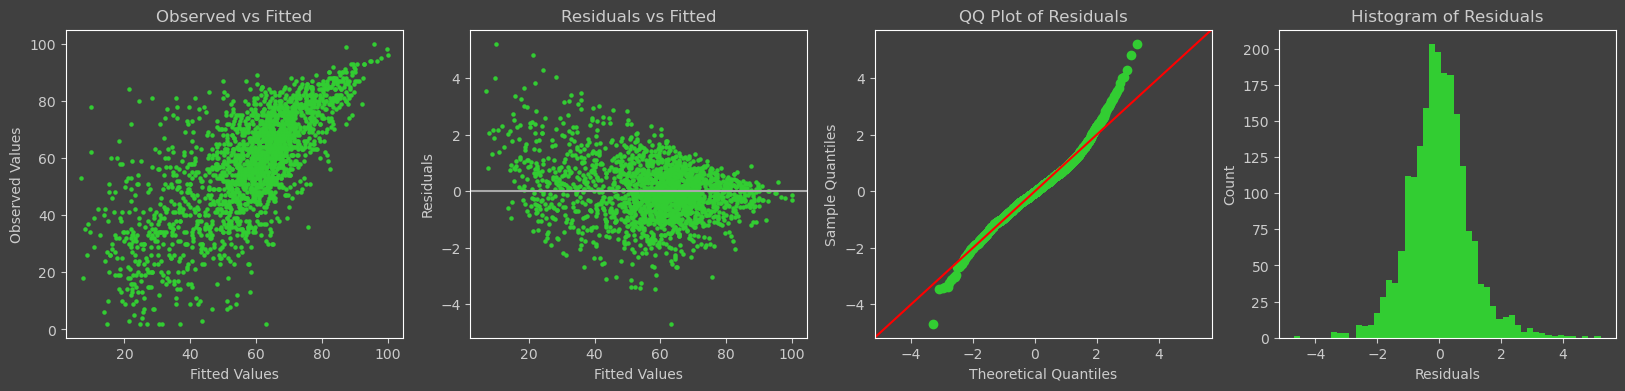

In [641]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

# Standardize residuals for multivariate regression
residuals = y_test_inv_scaled - y_pred
standardized_residuals = residuals / np.std(residuals)

# Observed vs Fitted
ax[0].scatter(x = y_pred, y = y_test_inv_scaled, s=5, c=color)
ax[0].set_title("Observed vs Fitted")
ax[0].set_xlabel("Fitted Values")
ax[0].set_ylabel("Observed Values")

# Residuals vs Fitted
ax[1].scatter(x = y_pred, y = standardized_residuals, s=5, c=color)
ax[1].axhline(y = 0, color='darkgrey')
ax[1].set_title("Residuals vs Fitted")
ax[1].set_xlabel("Fitted Values")
ax[1].set_ylabel("Residuals")

# QQ Plot of Residuals
sm.qqplot(standardized_residuals, line='45', fit=True, ax=ax[2], markerfacecolor=color, markeredgecolor=color)
ax[2].set_title("QQ Plot of Residuals")

# Histogram of Residuals
ax[3].hist(standardized_residuals, color=color, bins=50)
ax[3].set_title("Histogram of Residuals")
ax[3].set_xlabel("Residuals")
ax[3].set_ylabel("Count")

plt.show()

In [642]:
rmse = root_mean_squared_error(y_pred, y_test_inv_scaled)
rmse

13.049605314186554

#### SHAP

In [643]:
# Initialize the SHAP explainer
explainer = shap.Explainer(final_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

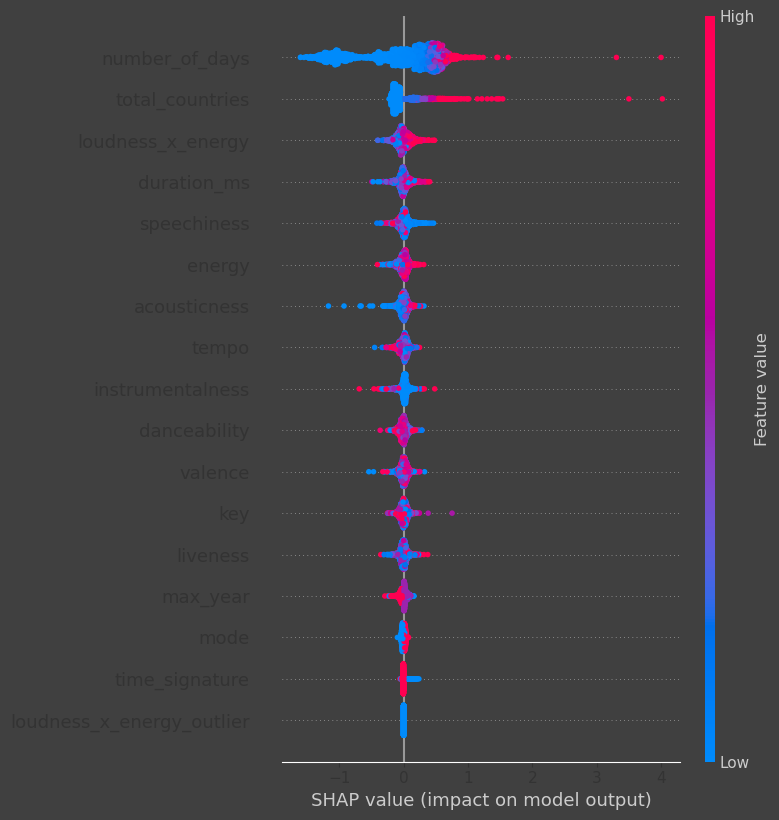

In [644]:
# Summary plot of feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

<Figure size 1200x400 with 0 Axes>

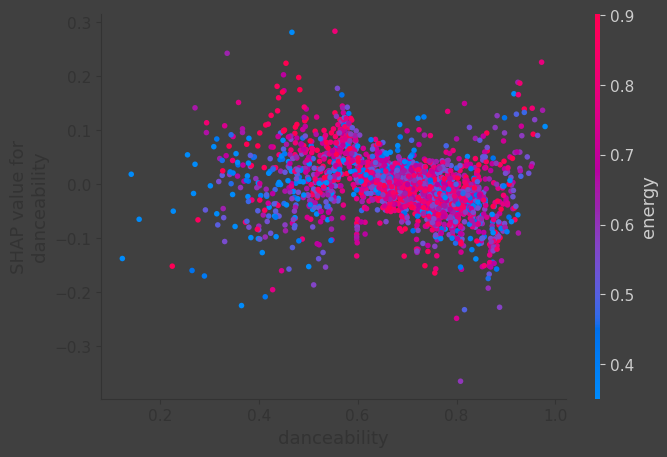

<Figure size 1200x400 with 0 Axes>

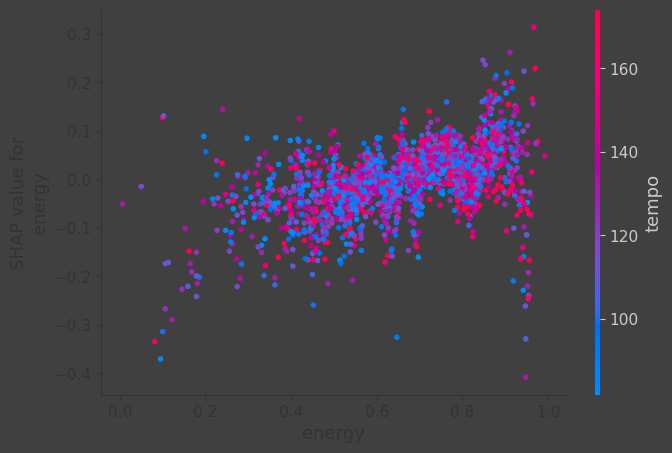

<Figure size 1200x400 with 0 Axes>

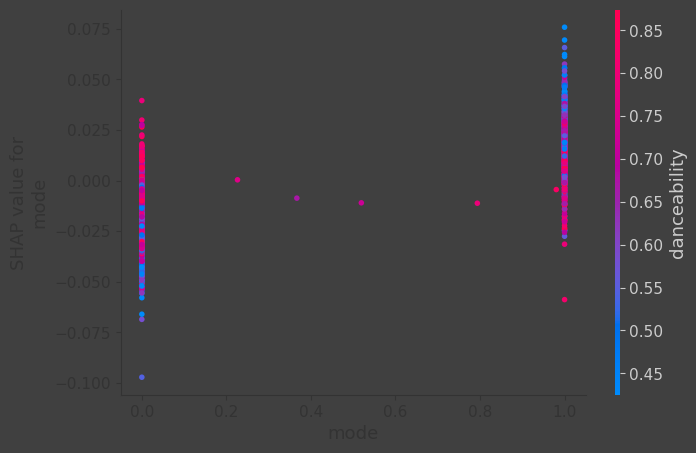

<Figure size 1200x400 with 0 Axes>

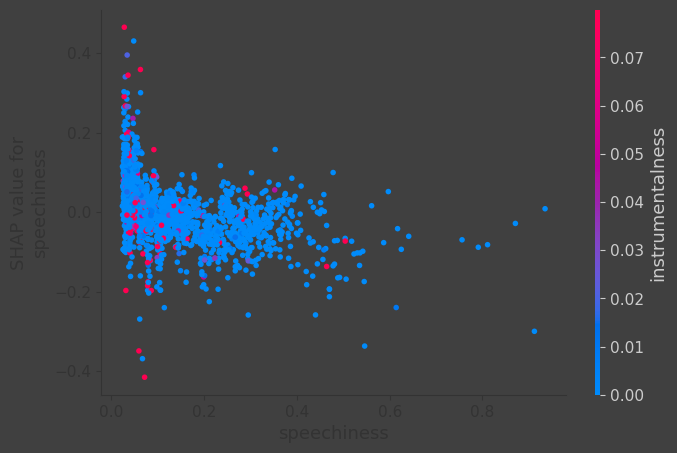

<Figure size 1200x400 with 0 Axes>

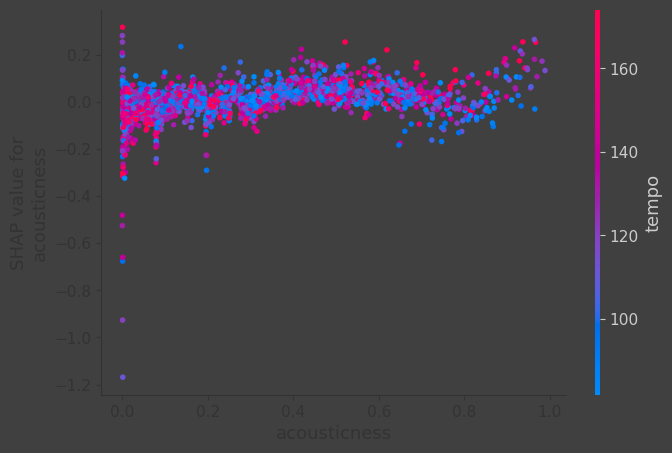

<Figure size 1200x400 with 0 Axes>

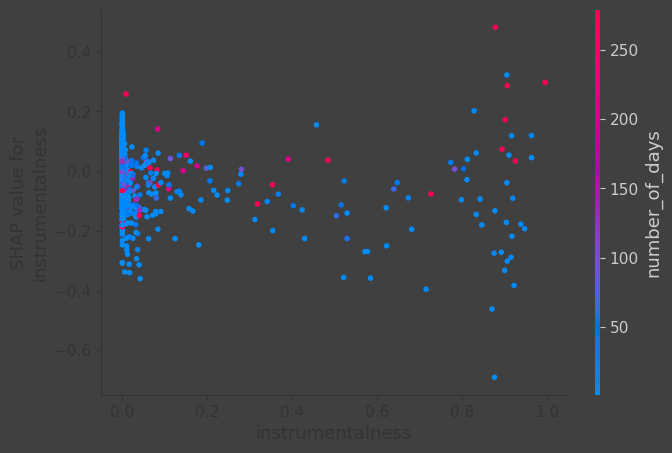

<Figure size 1200x400 with 0 Axes>

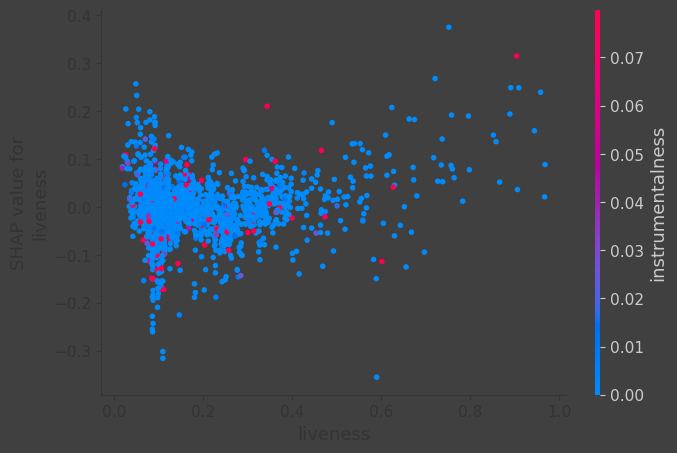

<Figure size 1200x400 with 0 Axes>

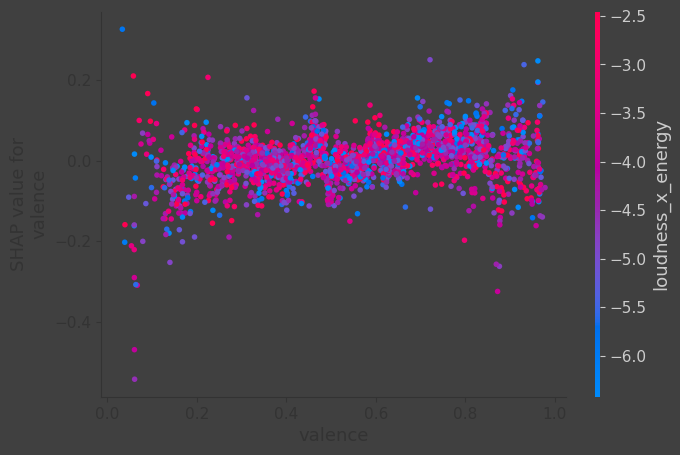

<Figure size 1200x400 with 0 Axes>

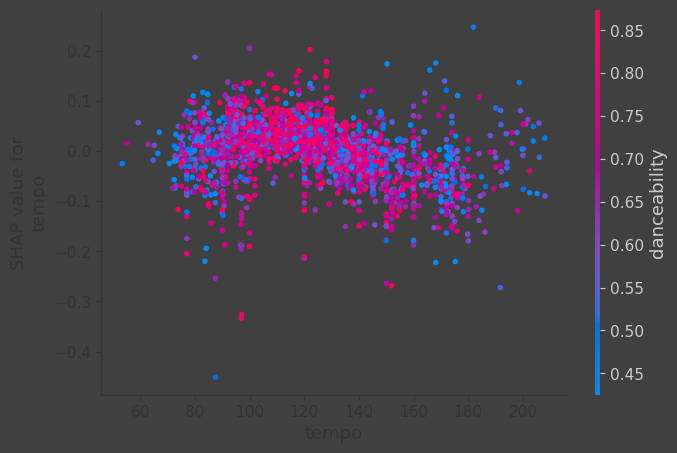

<Figure size 1200x400 with 0 Axes>

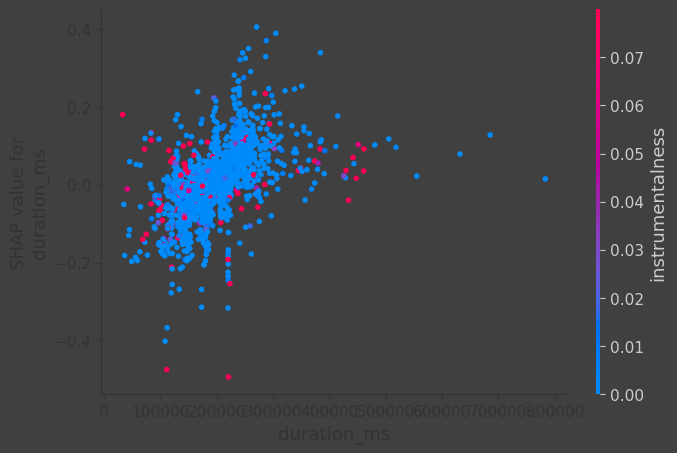

<Figure size 1200x400 with 0 Axes>

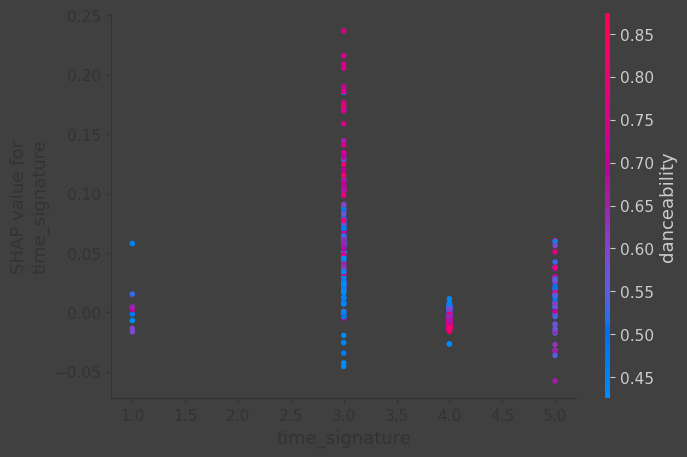

<Figure size 1200x400 with 0 Axes>

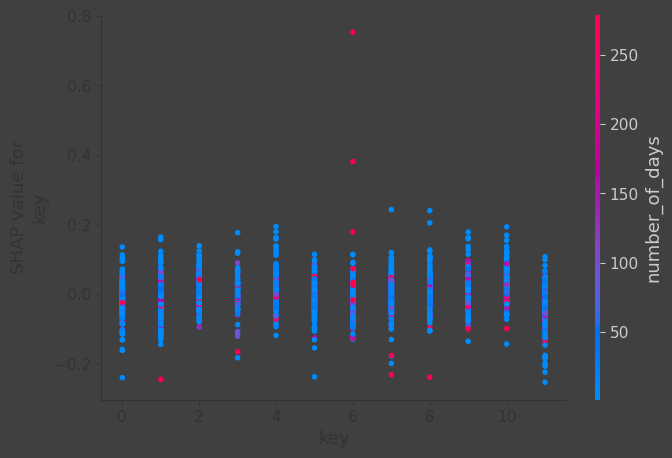

<Figure size 1200x400 with 0 Axes>

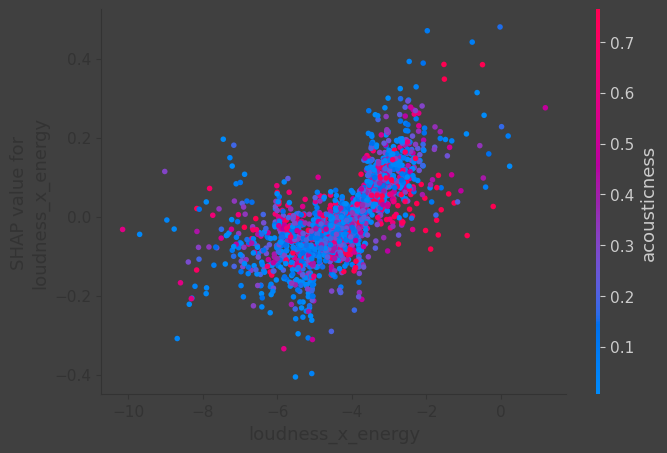

<Figure size 1200x400 with 0 Axes>

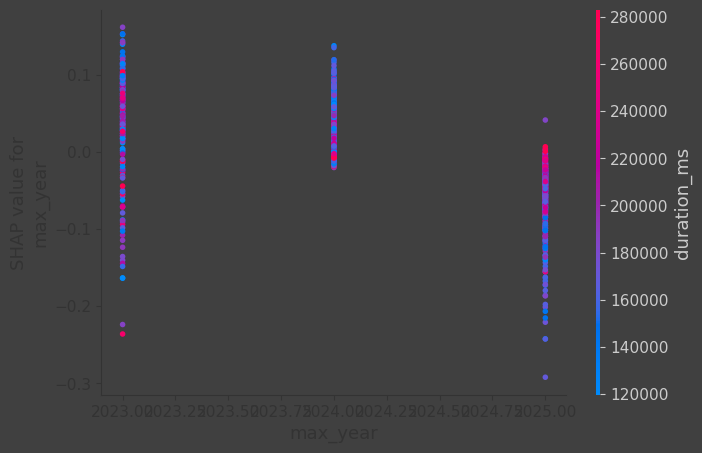

<Figure size 1200x400 with 0 Axes>

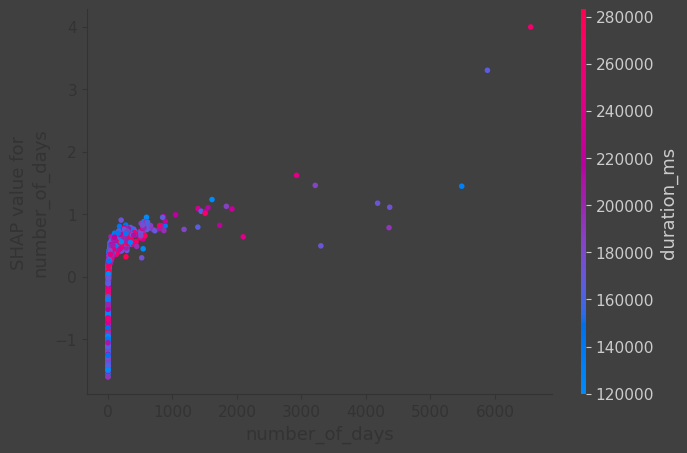

<Figure size 1200x400 with 0 Axes>

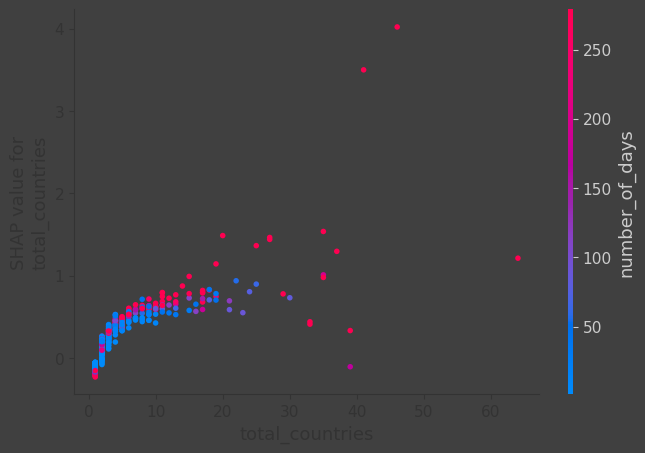

<Figure size 1200x400 with 0 Axes>

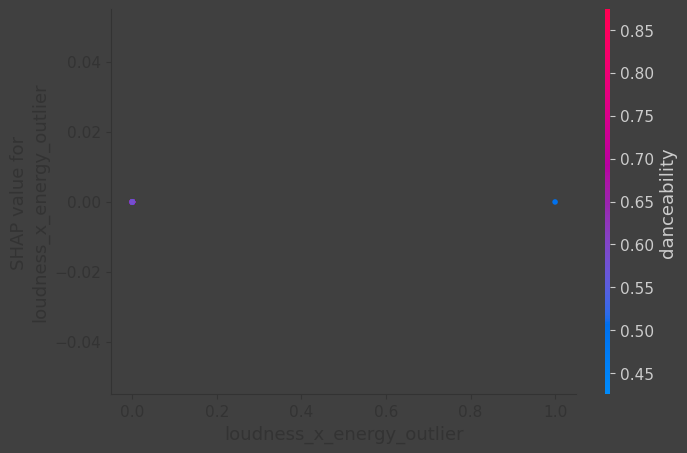

In [645]:
# Iterate through each feature name in X_test.columns
for feature in X_test.columns:
    plt.figure(figsize=(12, 4))
    shap.dependence_plot(feature, shap_values, X_test, feature_names=X_test.columns)
    plt.show()


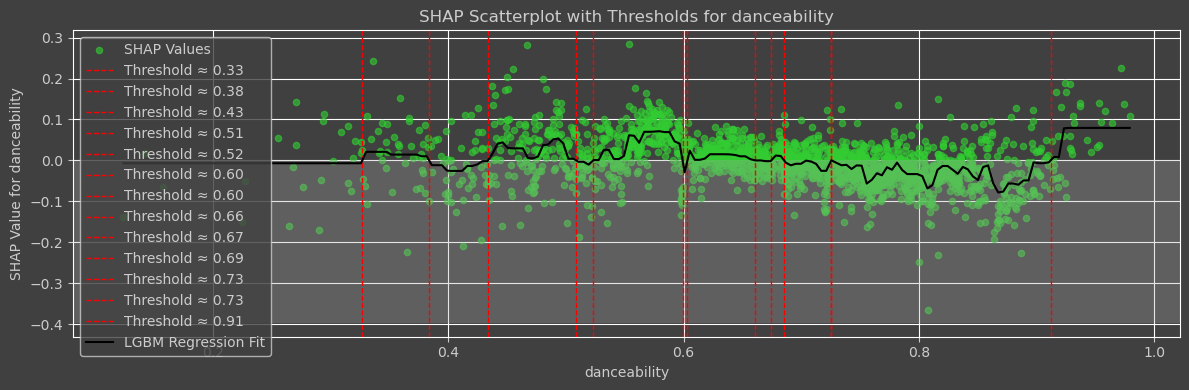

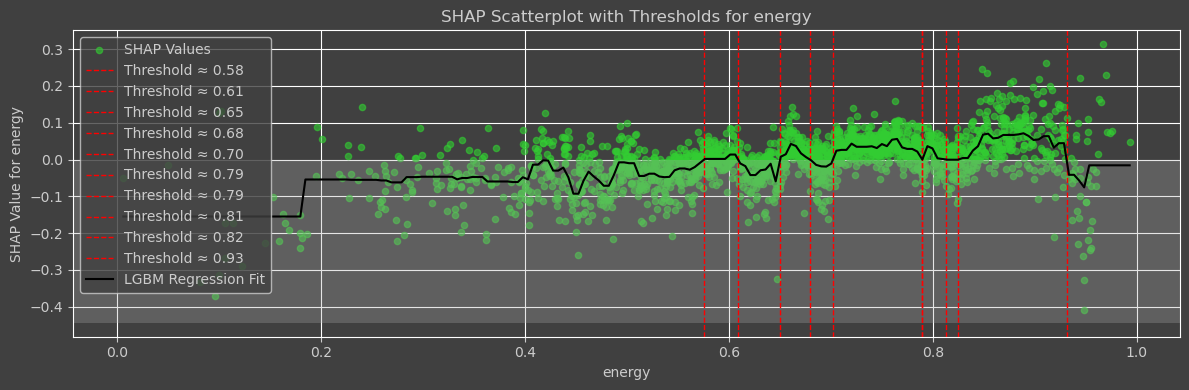

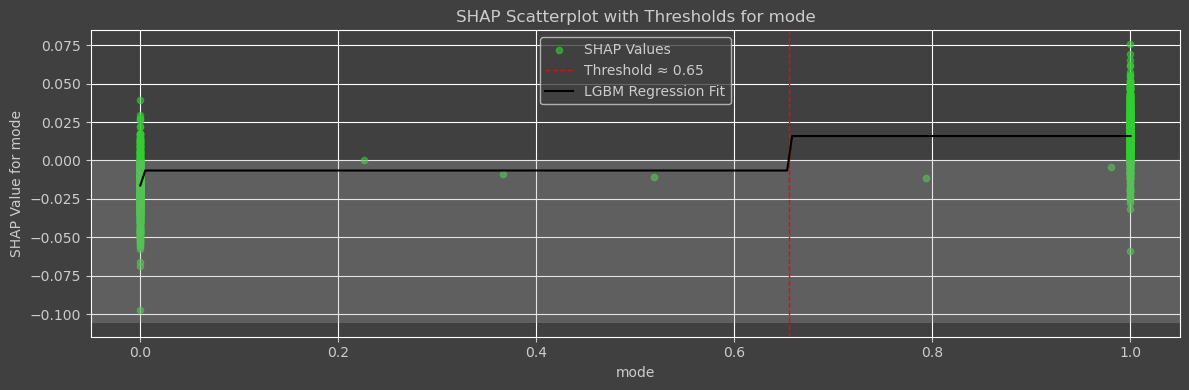

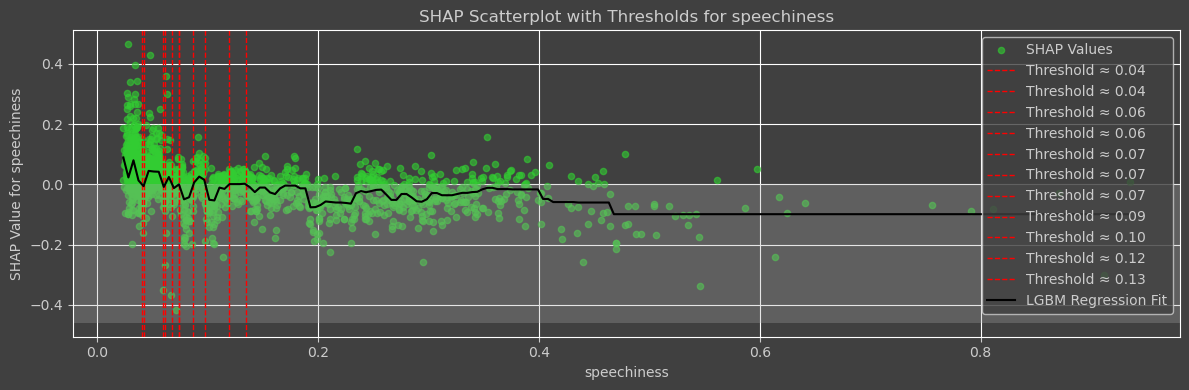

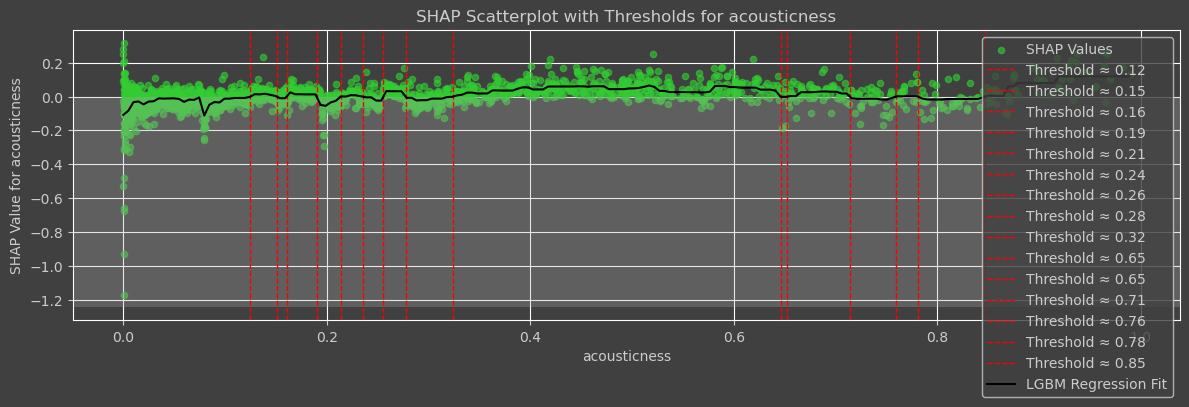

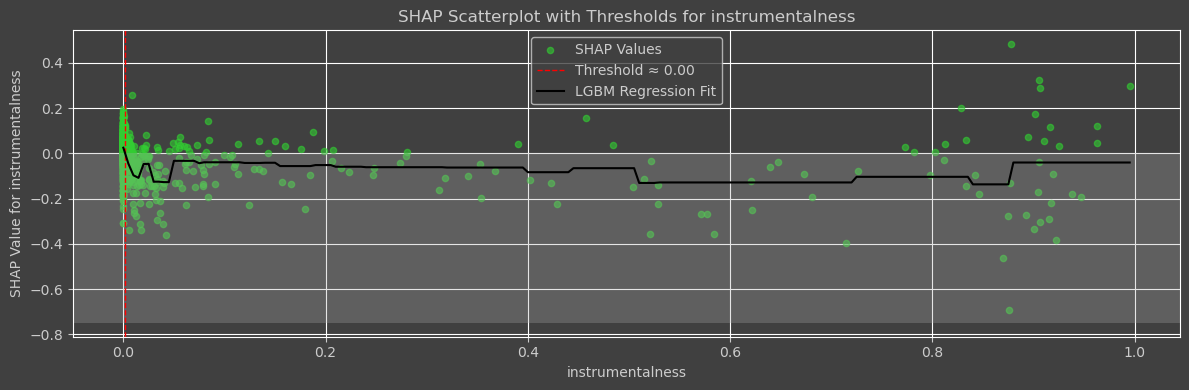

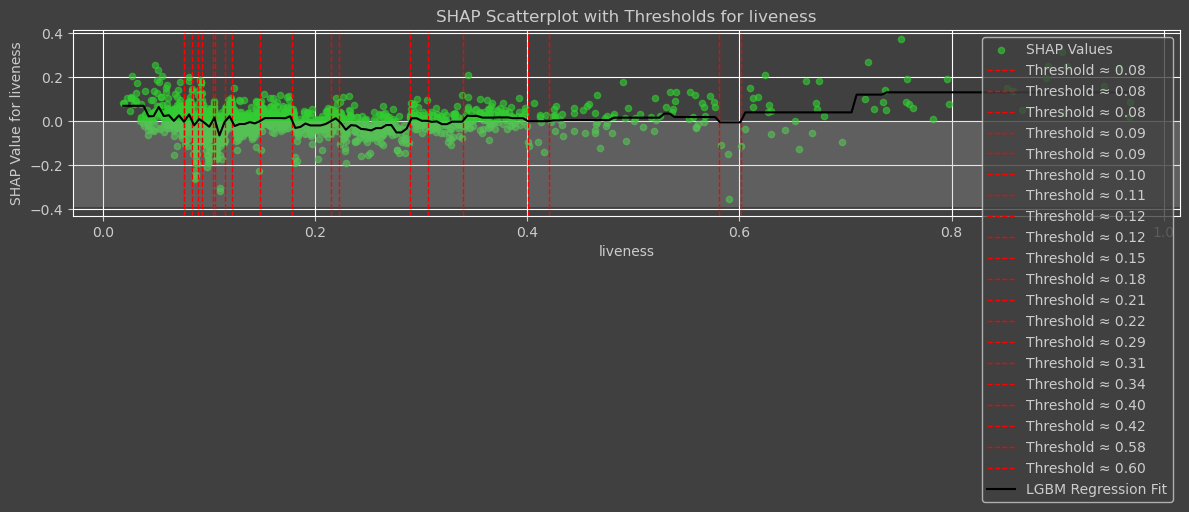

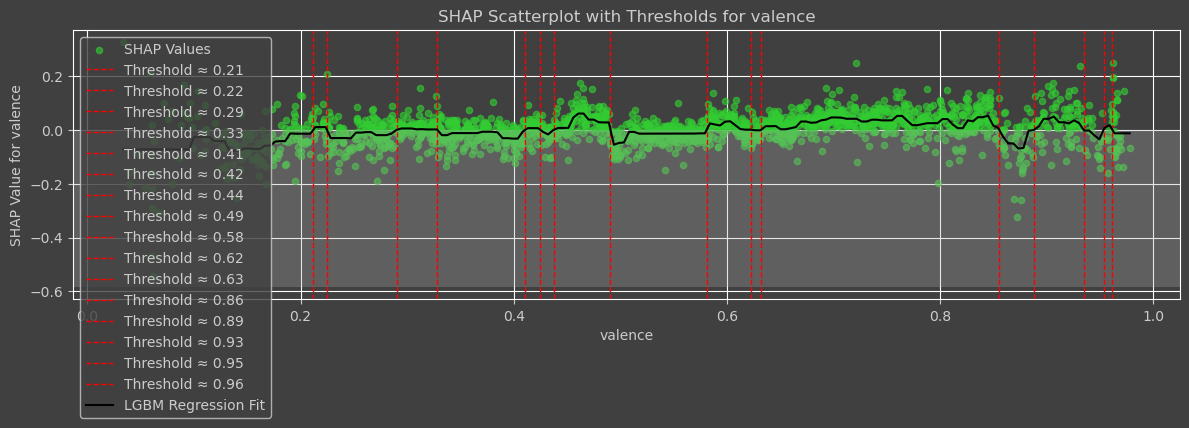

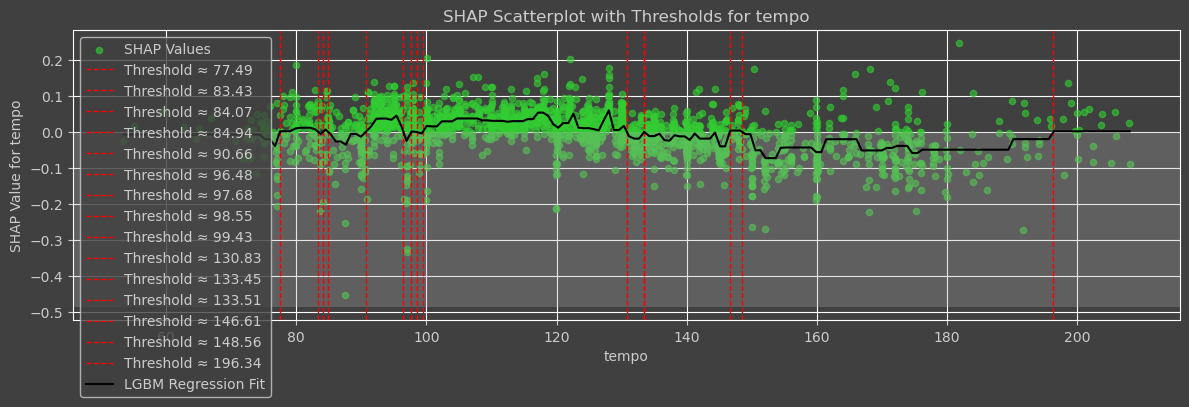

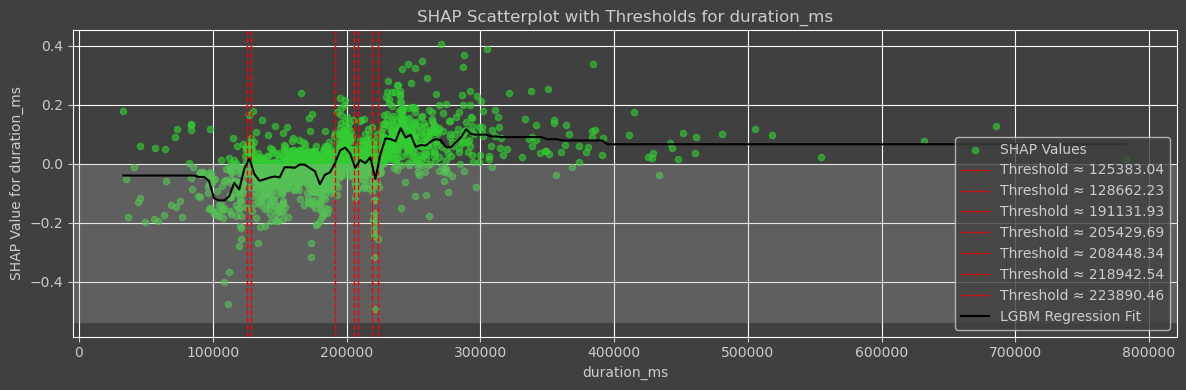

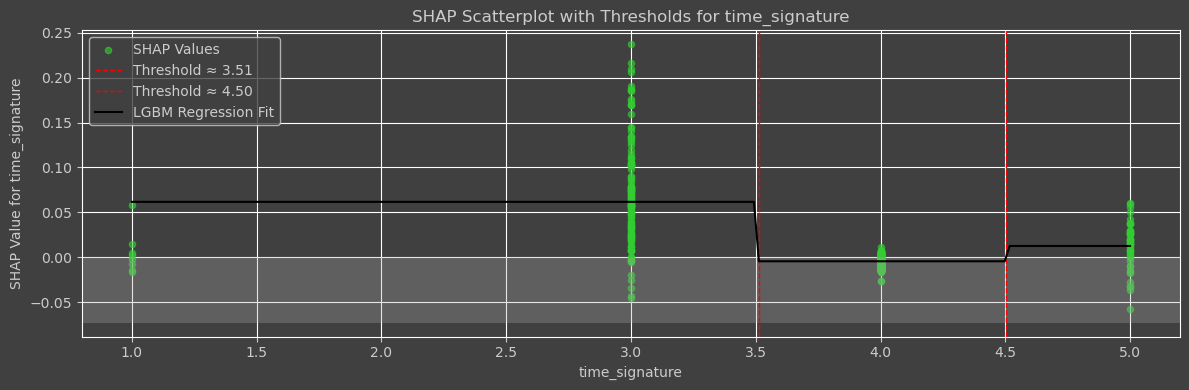

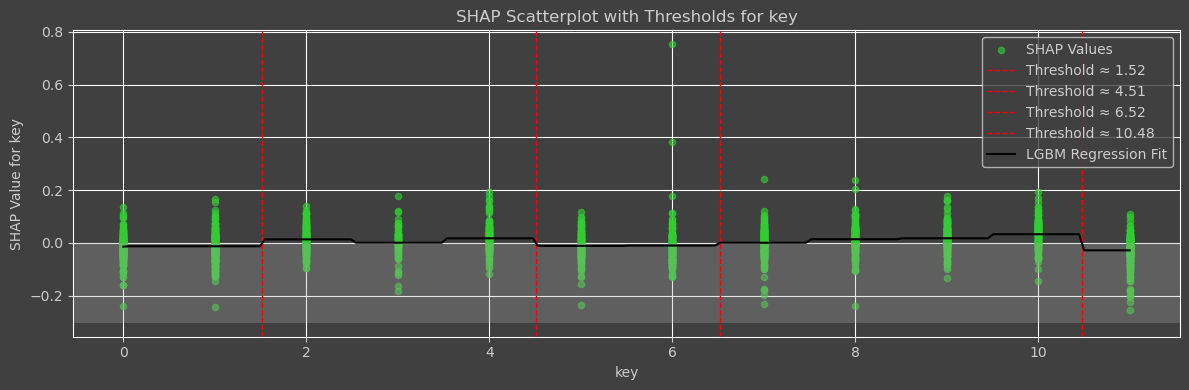

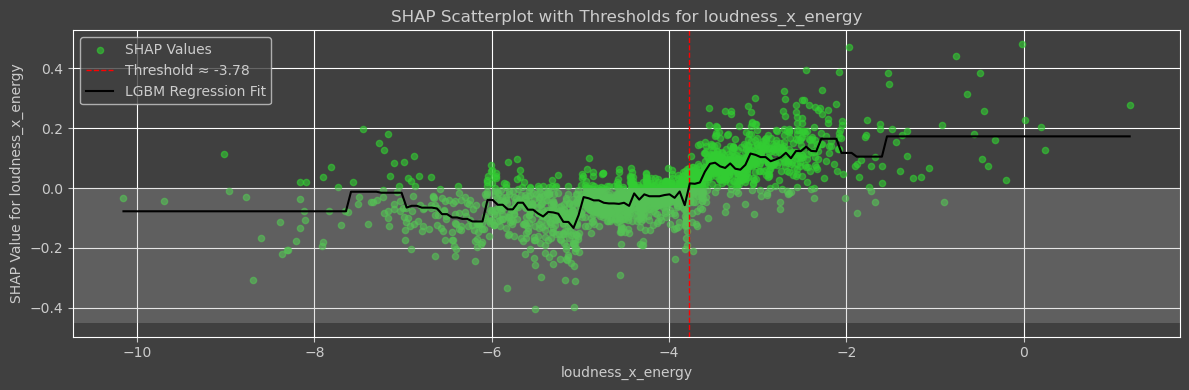

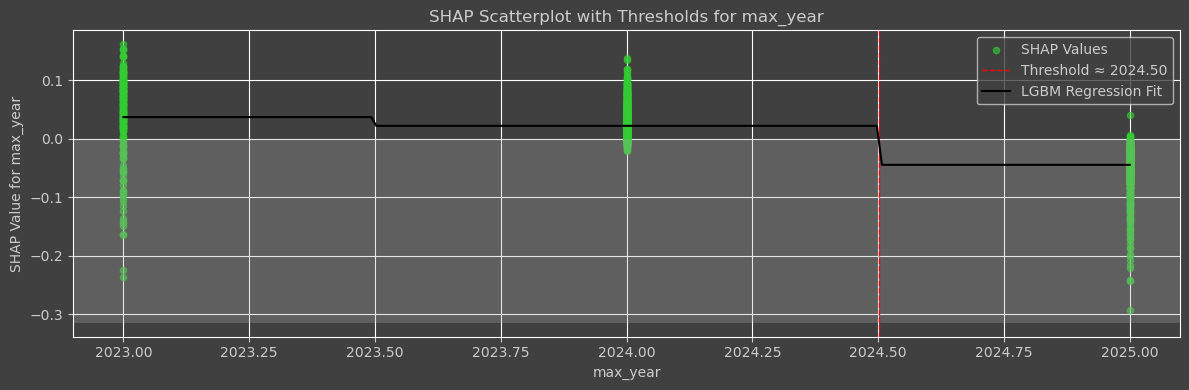

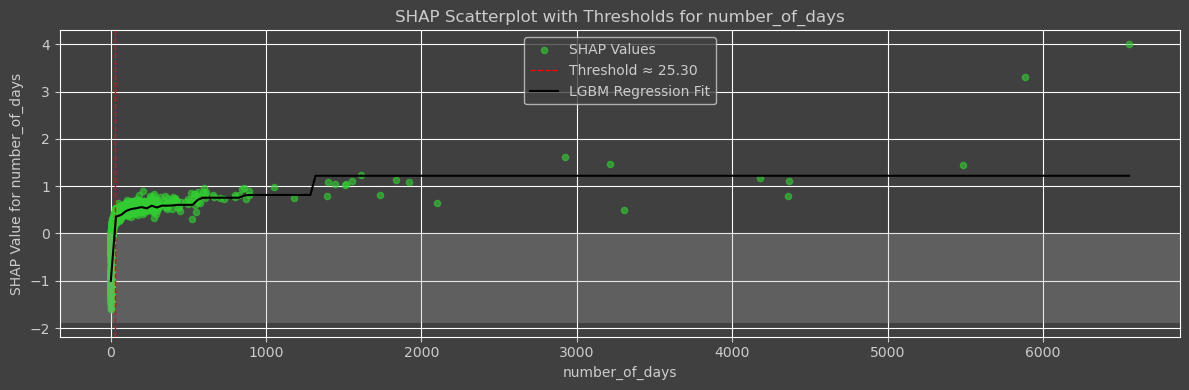

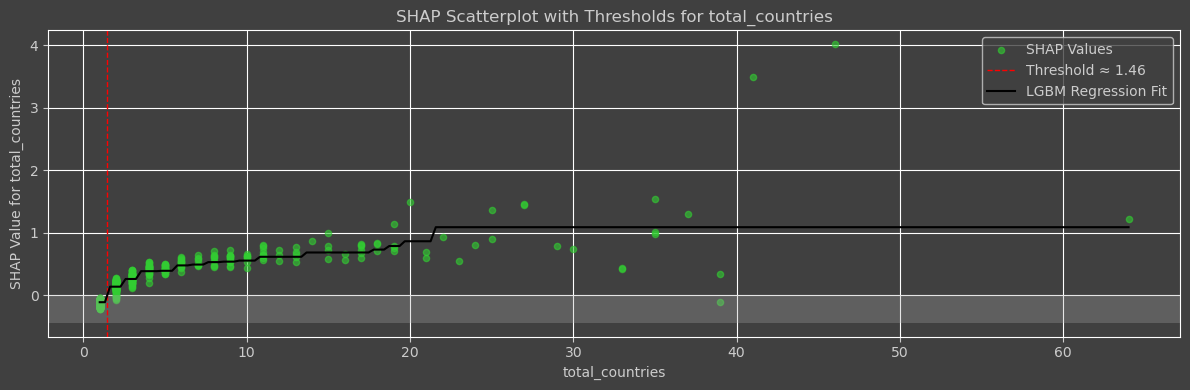

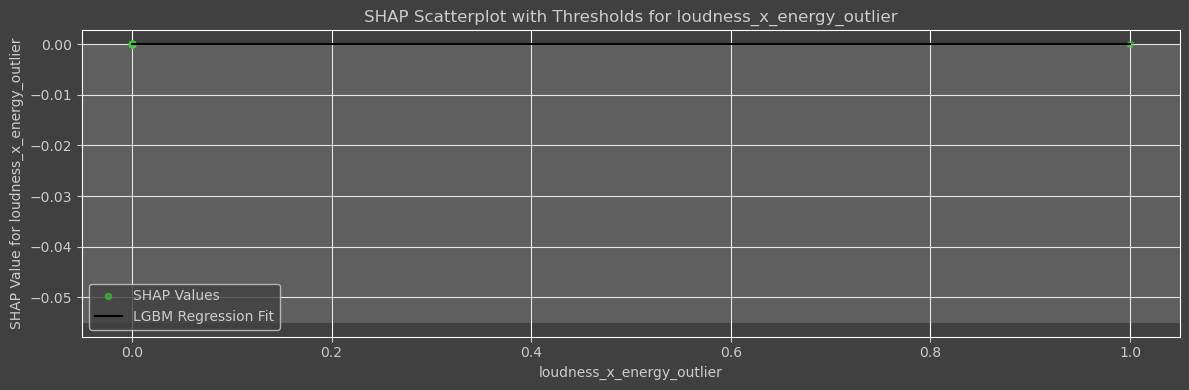

In [646]:
thresholds = {}

# Iterate through each feature
for i, feature_name in enumerate(X_test.columns):

    # SHAP values for the current feature
    feature_values = X_test[feature_name].values
    shap_feature_values = shap_values[:, i]

    # # Determine colors based on 'Quality'
    # colors = np.where(y_test == 1, good_color, bad_color)

    # Sort data for plotting and fitting
    sorted_indices = np.argsort(feature_values.flatten())
    sorted_feature_values = feature_values[sorted_indices]
    sorted_shap_feature_values = shap_feature_values[sorted_indices]
    # sorted_colors = colors[sorted_indices]

    # Convert sorted_feature_values to a DataFrame for the regressor
    X_fit_regressor = pd.DataFrame(sorted_feature_values.reshape(-1, 1), columns=[feature_name])

    # Fit a small LightGBMRegressor
    lgbm_reg = lgb.LGBMRegressor(objective='regression', n_estimators=25, learning_rate=0.1, random_state=42, silent=True)
    lgbm_reg.fit(X_fit_regressor, sorted_shap_feature_values)

    # Predict SHAP value for a range of feature values
    feature_range_values = np.linspace(sorted_feature_values.min(), sorted_feature_values.max(), 200)
    X_predict_regressor = pd.DataFrame(feature_range_values.reshape(-1, 1), columns=[feature_name])
    predicted_shap = lgbm_reg.predict(X_predict_regressor)

    # Find approximate zero-crossing points
    zero_crossings = []
    sign_changes = np.where(np.diff(np.sign(predicted_shap)))[0]
    for idx in sign_changes:
        # Linear interpolation to approximate the zero-crossing value
        x1, y1 = feature_range_values[idx], predicted_shap[idx]
        x2, y2 = feature_range_values[idx + 1], predicted_shap[idx + 1]
        if y1 * y2 < 0:  # Ensure a sign change occurred
            zero_crossing = x1 - y1 * (x2 - x1) / (y2 - y1)
            zero_crossings.append(zero_crossing)

    # Store the results
    thresholds[feature_name] = {
        'Predicted Thresholds': zero_crossings,
        'Mean': X_test[feature_name].mean(),
        'Median': X_test[feature_name].median()
    }

    # Create the DataFrame from the dictionary
    results_df = pd.DataFrame.from_dict(thresholds, orient='index')

    # Plot the SHAP Threshold Scatterplot
    plt.figure(figsize=(12, 4))
    plt.scatter(sorted_feature_values, sorted_shap_feature_values, s=20,  c=color, alpha=0.6, label='SHAP Values')
    # plt.scatter(sorted_feature_values, sorted_shap_feature_values, s=20, c=sorted_colors, alpha=0.6, label='SHAP Values')
    # Add red vertical lines for each zero crossing
    for crossing in zero_crossings:
        plt.axvline(x=crossing, color='red', linestyle='--', linewidth=1, label=f'Threshold ≈ {crossing:.2f}')
    y_min, y_max = plt.ylim()
    plt.axhspan(y_min, 0, facecolor='darkgrey', alpha=0.3)
    plt.plot(feature_range_values, predicted_shap, color='black', linestyle='-', label='LGBM Regression Fit')
    plt.xlabel(feature_name)
    plt.ylabel(f'SHAP Value for {feature_name}')
    plt.title(f'SHAP Scatterplot with Thresholds for {feature_name}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [647]:
# Print the DataFrame with all zero-crossing points
print("DataFrame of Predicted Thresholds:")
results_df['Predicted Thresholds'] = results_df['Predicted Thresholds'].apply(lambda x: [val.round(2) for val in x])
results_df.round(2)

DataFrame of Predicted Thresholds:


Predicted Thresholds  \
danceability               [0.33, 0.38, 0.43, 0.51, 0.52, 0.6, 0.6, 0.66,...   
energy                     [0.58, 0.61, 0.65, 0.68, 0.7, 0.79, 0.79, 0.81...   
mode                                                                  [0.65]   
speechiness                [0.04, 0.04, 0.06, 0.06, 0.07, 0.07, 0.07, 0.0...   
acousticness               [0.12, 0.15, 0.16, 0.19, 0.21, 0.24, 0.26, 0.2...   
instrumentalness                                                       [0.0]   
liveness                   [0.08, 0.08, 0.08, 0.09, 0.09, 0.1, 0.11, 0.12...   
valence                    [0.21, 0.22, 0.29, 0.33, 0.41, 0.42, 0.44, 0.4...   
tempo                      [77.49, 83.43, 84.07, 84.94, 90.66, 96.48, 97....   
duration_ms                [125383.04, 128662.23, 191131.93, 205429.69, 2...   
time_signature                                                   [3.51, 4.5]   
key                                                [1.52, 4.51, 6.52, 10.48]   
loudness_x_energy                                                    [-3.78]   
max_year                                                            [2024.5]   
number_of_days                                                        [25.3]   
total_countries                                                       [1.46]   
loudness_x_energy_outlier                                                 []   

                                Mean     Median  
danceability                    0.67       0.69  
energy                          0.66       0.68  
mode                            0.51       1.00  
speechiness                     0.12       0.07  
acousticness                    0.27       0.19  
instrumentalness                0.03       0.00  
liveness                        0.18       0.13  
valence                         0.54       0.54  
tempo                         123.09     122.00  
duration_ms                189693.98  180746.00  
time_signature                  3.95       4.00  
key                             5.37       6.00  
loudness_x_energy              -4.24      -4.16  
max_year                     2024.27    2024.00  
number_of_days                 82.58      11.00  
total_countries                 2.00       1.00  
loudness_x_energy_outlier       0.00       0.00

### SHAP Characteristics of a Hit Song

In [657]:
# Grab SHAP values for each prediction
shap_df = pd.DataFrame(shap_values, columns=[f'{col}_SHAP' for col in X_test.columns], index=X_test.index)

# It's good practice to keep the original (or scaled) features alongside their SHAP values
X_test_with_shap = pd.concat([X_test, shap_df], axis=1)

# Also add the actual popularity score from y_test for analysis
X_test_with_shap['popularity'] = y_test_inv_scaled

X_test_with_shap

danceability    energy  mode  speechiness  acousticness  \
13142      0.659000  0.622000   1.0     0.032400      0.655000   
9476       0.692000  0.751000   1.0     0.168000      0.092800   
7435       0.688000  0.550000   0.0     0.072700      0.150000   
219        0.748000  0.551000   1.0     0.045800      0.736000   
12090      0.507000  0.662000   0.0     0.093900      0.423000   
...             ...       ...   ...          ...           ...   
7063       0.728707  0.583886   1.0     0.044773      0.278041   
15162      0.673000  0.740000   0.0     0.045200      0.017100   
9202       0.644000  0.696000   0.0     0.158000      0.359000   
11135      0.736000  0.683000   1.0     0.152000      0.008200   
8681       0.785000  0.688000   1.0     0.058600      0.093600   

       instrumentalness  liveness   valence       tempo    duration_ms  \
13142          0.000000  0.196000  0.304000  136.074000  269133.000000   
9476           0.000009  0.124000  0.741000  140.023000  264000.000000   
7435           0.000884  0.240000  0.346000  146.014000  230975.000000   
219            0.000163  0.096000  0.626000  107.933000  136280.000000   
12090          0.000000  0.154000  0.277000   84.607000  172235.000000   
...                 ...       ...       ...         ...            ...   
7063           0.000000  0.111813  0.639187   79.980382  175272.682927   
15162          0.000023  0.101000  0.211000  106.966000  176957.000000   
9202           0.000000  0.087100  0.650000  177.773000  145617.000000   
11135          0.000000  0.161000  0.233000  129.893000  177273.000000   
8681           0.000000  0.275000  0.393000   99.998000  126750.000000   

       time_signature  key  loudness_x_energy  max_year  number_of_days  \
13142               4    7          -4.571078    2023.0             2.0   
9476                4    1          -5.807483    2024.0             8.0   
7435                4    0          -5.874550    2024.0             3.0   
219                 4    1          -4.071339    2023.0            40.0   
12090               4    3          -3.606576    2025.0             2.0   
...               ...  ...                ...       ...             ...   
7063                4    7          -3.995475    2024.0           123.0   
15162               4    5          -3.986380    2025.0           110.0   
9202                4   10          -3.560736    2024.0           286.0   
11135               4    1          -3.756500    2024.0             1.0   
8681                4    0          -4.937088    2024.0            36.0   

       total_countries  loudness_x_energy_outlier  danceability_SHAP  \
13142              1.0                          0          -0.003153   
9476               1.0                          0          -0.025634   
7435               2.0                          0          -0.028259   
219                2.0                          0           0.010742   
12090              1.0                          0          -0.030745   
...                ...                        ...                ...   
7063               2.0                          0           0.003014   
15162             11.0                          0          -0.023972   
9202               1.0                          0           0.058891   
11135              1.0                          0          -0.039638   
8681               1.0                          0          -0.046778   

       energy_SHAP  mode_SHAP  speechiness_SHAP  acousticness_SHAP  \
13142    -0.087066   0.016291          0.046460           0.011546   
9476      0.051190   0.005697         -0.035624          -0.028139   
7435     -0.002048  -0.012185         -0.027312           0.000470   
219      -0.040528   0.027780          0.036520           0.000031   
12090     0.033821  -0.017878          0.016258           0.067944   
...            ...        ...               ...                ...   
7063      0.029921   0.031258          0.027817           0.014419   

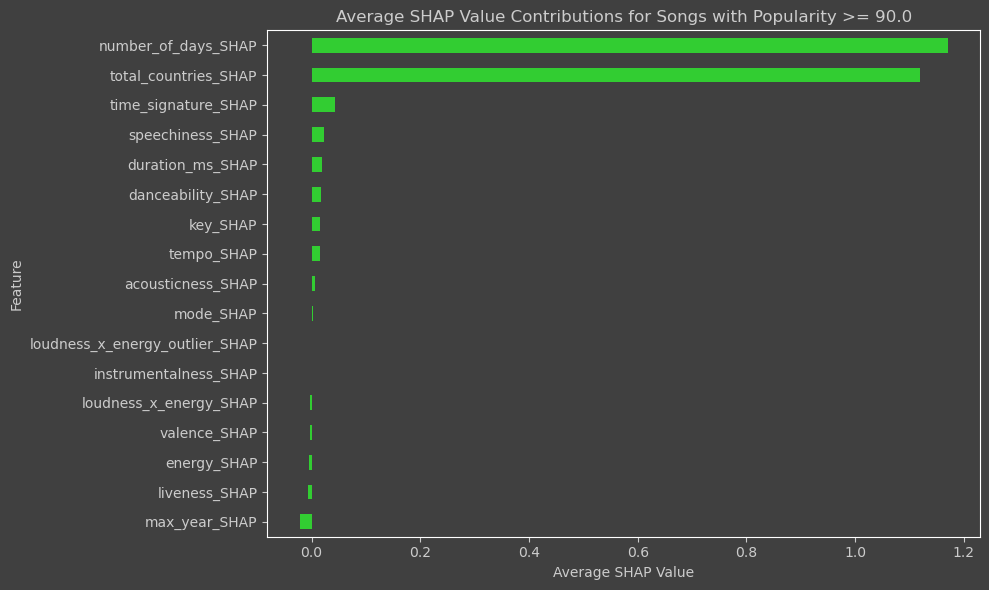

In [658]:
# Calculate the Nth percentile of the 'popularity' column
popularity_threshold = X_test_with_shap['popularity'].quantile(0.99)

# Filter for highly popular songs in the test set
highly_popular_songs = X_test_with_shap[X_test_with_shap['popularity'] >= popularity_threshold]

if highly_popular_songs.empty:
    print(f"\nNo songs found with 'popularity' >= {popularity_threshold} in the test set.")
else:
    # Select only the SHAP value columns
    shap_value_columns = [col for col in highly_popular_songs.columns if col.endswith('_SHAP')]
    shap_values_for_popular_songs = highly_popular_songs[shap_value_columns]

    # Calculate the average SHAP value for each feature among popular songs
    average_shap_contributions = shap_values_for_popular_songs.mean()

    # You can even visualize this
    plt.figure(figsize=(10, 6))
    average_shap_contributions.sort_values(ascending=True).plot(kind='barh', color=color)
    plt.title(f'Average SHAP Value Contributions for Songs with Popularity >= {popularity_threshold.round(3)}')
    plt.xlabel('Average SHAP Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [ ]:
# Also look at the average feature values themselves for popular songs
print(f"\nAverage Feature values for songs with popularity >= {popularity_threshold.round(3)} (on scaled data):")
average_features_popular_songs = highly_popular_songs[X.columns].mean()
hit_song =  pd.DataFrame([average_features_popular_songs])
# We don't want to match on non-musical features
hit_song.drop(['number_of_days', 'total_countries', 'max_year'], axis=1, inplace=True)
hit_song


Average Feature values for songs with popularity >= 90.0 (on scaled data):


danceability   energy  mode  speechiness  acousticness  instrumentalness  \
0      0.606811  0.62157  0.56     0.091387      0.325029          0.042277   

   liveness   valence       tempo    duration_ms  time_signature   key  \
0  0.195654  0.492661  130.762994  193878.140219            3.76  4.96   

   loudness_x_energy  loudness_x_energy_outlier  
0           -3.83225                        0.0

In [ ]:
all_songs = df[['name'] + features].drop_duplicates(subset='name').copy().reset_index(drop=True)
# We don't want to match on non-musical features
all_songs.drop(['number_of_days', 'total_countries', 'max_year'], axis=1, inplace=True)
all_songs

name  danceability  energy  \
0                              "Heal'lang"(folang)         0.900   0.759   
1                                             "Se"         0.740   0.765   
2      "Slut!" (Taylor's Version) (From The Vault)         0.629   0.413   
3                                     "conspiracy"         0.842   0.402   
4                                       #BÂTIMENT1         0.673   0.565   
...                                            ...           ...     ...   
20877                              별별별 (See that?)         0.603   0.824   
20878                              보나마나 (BONAMANA)         0.800   0.389   
20879                                          예뻤어         0.460   0.615   
20880                                         작은 봄         0.586   0.581   
20881                                한 페이지가 될 수 있게         0.510   0.975   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0       1.0       0.1780       0.04290          0.000006    0.2280   0.5960   
1       0.0       0.0622       0.18600          0.488000    0.1350   0.5480   
2       1.0       0.0550       0.34500          0.000076    0.0603   0.3060   
3       0.0       0.2470       0.10000          0.000000    0.1060   0.3140   
4       1.0       0.1610       0.56600          0.000000    0.1110   0.0857   
...     ...          ...           ...               ...       ...      ...   
20877   1.0       0.2750       0.03590          0.000000    0.1130   0.5270   
20878   0.0       0.0550       0.52300          0.000000    0.1190   0.6850   
20879   0.0       0.0331       0.06330          0.000000    0.1090   0.4140   
20880   1.0       0.0248       0.05780          0.000000    0.1130   0.2680   
20881   1.0       0.0530       0.00428          0.000000    0.2220   0.7470   

         tempo  duration_ms  time_signature  key  loudness_x_energy  \
0      125.001     273711.0               4    2          -3.384381   
1      131.986     145511.0               4    7          -4.260285   
2       77.983     180381.0               4    7          -5.442514   
3      149.930     183003.0               4   10          -3.312882   
4      148.988     129522.0               4    1          -4.862390   
...        ...          ...             ...  ...                ...   
20877  183.936     182795.0               4    8          -2.412672   
20878  129.861     195536.0               4    0          -3.884943   
20879  167.927     283160.0               4    5          -2.135280   
20880  109.969     222040.0               4    4          -3.660300   
20881  174.973     205575.0               4    8          -2.689050   

       loudness_x_energy_outlier  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  
...                          ...  
20877                          0  
20878                          0  
20879                          0  
20880                          0  
20881                          0  

[20882 rows x 15 columns]

#### KNN Classifier

In [ ]:
# Filter data to find similar songs from a certain country only
filter_df = checkpoint_df[checkpoint_df['country']=='US']
all_songs = all_songs[all_songs['name'].isin(filter_df['name'].unique().tolist())].reset_index(drop=True)

In [ ]:
# Fit a KNN Classifier
knn = KNeighborsClassifier(n_neighbors = 30)
all_songs_features = all_songs[hit_song.columns.tolist()]
knn.fit(all_songs_features, all_songs_features.index)

# Find the 1-NN for a hit song, using the average of the Nth percentile of popular songs to find a similar song from our data
y_pred = knn.predict(hit_song)
y_pred = pd.DataFrame(y_pred)

y_pred

0
0  42

In [ ]:
# The index of our 1-NN to a hit song
y_pred.values[0]

array([42])

In [ ]:
# Locate this song using the index
all_songs.iloc[y_pred.values[0]]

name  danceability  energy  mode  \
42  All You Had To Do Was Stay (Taylor's Version)         0.586    0.72   1.0   

    speechiness  acousticness  instrumentalness  liveness  valence   tempo  \
42        0.035      0.000718               0.0    0.0949    0.481  97.057   

    duration_ms  time_signature  key  loudness_x_energy  \
42     193289.0               4    0           -4.00032   

    loudness_x_energy_outlier  
42                          0